In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import folium
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pylab import rcParams
import re
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
from pandas import Grouper
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from fbprophet import Prophet as proph
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from sklearn import preprocessing

%matplotlib inline

Using TensorFlow backend.


In [5]:
import geopandas

> ## Energy Prices from EIA https://www.eia.gov/
> ## Weather Data https://www.ncdc.noaa.gov/
> ## Global Energy Consumption https://yearbook.enerdata.net/total-energy/world-consumption-statistics.html
> ### Dapeng LNG terminal - main terminal for importing LNG in China
> ### Shenzhen LNG main terminal  major city in Guangdong Province, China

In [6]:
LNG = pd.read_excel("LNGMonthlyPrices.xls", sheet_name= 1 )

In [7]:
WTI = pd.read_excel("WTICrudeDaily.xls", sheet_name= 1 )

In [8]:
NAT= pd.read_excel('HHNatGas.xls', sheet_name=1)

In [9]:
LNG.tail()

Back to Contents  \
220  2018-09-15 00:00:00   
221  2018-10-15 00:00:00   
222  2018-11-15 00:00:00   
223  2018-12-15 00:00:00   
224  2019-01-15 00:00:00   

    Data 1: Price of Liquefied U.S. Natural Gas Exports (Dollars per Thousand Cubic Feet)  
220                                               4.78                                     
221                                               4.92                                     
222                                               5.62                                     
223                                               6.84                                     
224                                               5.89

In [10]:
WTI.tail()

Back to Contents  \
8388  2019-04-09 00:00:00   
8389  2019-04-10 00:00:00   
8390  2019-04-11 00:00:00   
8391  2019-04-12 00:00:00   
8392  2019-04-15 00:00:00   

     Data 1: Cushing, OK WTI Spot Price FOB (Dollars per Barrel)  
8388                                              64.05           
8389                                              64.62           
8390                                              63.61           
8391                                              63.86           
8392                                              63.43

In [11]:
NAT.tail()

Back to Contents  \
5599  2019-04-09 00:00:00   
5600  2019-04-10 00:00:00   
5601  2019-04-11 00:00:00   
5602  2019-04-12 00:00:00   
5603  2019-04-15 00:00:00   

     Data 1: Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  
5599                                               2.71                  
5600                                               2.72                  
5601                                               2.72                  
5602                                               2.75                  
5603                                               2.75

In [12]:
LNG.columns = ['Date', 'Price of Liquefied U.S. Natural Gas Exports (Dollars per Thousand Cubic Feet']

In [13]:
WTI.columns = ['Date', 'WTI Spot Price FOB (Dollars per Barrel)']

In [14]:
NAT.columns = ['Date', 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)']

In [15]:
LNG.drop([0,1], axis=0 , inplace= True)

In [16]:
WTI.drop([0,1], axis=0 , inplace= True)

In [17]:
NAT.drop([0,1], axis=0 , inplace= True)

In [18]:
LNG.head()

Date  \
2  1997-01-15 00:00:00   
3  1997-02-15 00:00:00   
4  1997-03-15 00:00:00   
5  1997-04-15 00:00:00   
6  1997-05-15 00:00:00   

  Price of Liquefied U.S. Natural Gas Exports (Dollars per Thousand Cubic Feet  
2                                               4.25                            
3                                               4.29                            
4                                               4.22                            
5                                               4.06                            
6                                               3.98

In [19]:
NAT.head()

Date  \
2  1997-01-07 00:00:00   
3  1997-01-08 00:00:00   
4  1997-01-09 00:00:00   
5  1997-01-10 00:00:00   
6  1997-01-13 00:00:00   

  Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  
2                                               3.82          
3                                                3.8          
4                                               3.61          
5                                               3.92          
6                                                  4

In [20]:
LNG["Date"]= pd.to_datetime(LNG["Date"])
LNG.set_index('Date', inplace= True)

In [21]:
WTI["Date"]= pd.to_datetime(WTI["Date"])
WTI.set_index('Date', inplace= True)

In [22]:
NAT["Date"]= pd.to_datetime(NAT["Date"])
NAT.set_index('Date', inplace= True)

In [23]:
energyPrices = WTI.join([LNG,NAT])

In [24]:
energyPrices.dropna(inplace=True, axis=0)

In [25]:
energyPrices

WTI Spot Price FOB (Dollars per Barrel)  \
Date                                                 
1997-01-15                                   25.95   
1997-04-15                                    19.6   
1997-05-15                                    21.3   
2001-02-15                                   28.96   
2001-03-15                                   26.56   
2001-05-15                                    28.9   
2001-06-15                                   28.52   
2001-08-15                                   27.51   
2001-10-15                                   22.37   
2001-11-15                                    17.5   
2002-01-15                                   18.99   
2002-02-15                                   21.47   
2002-03-15                                   24.47   
2002-04-15                                   24.53   
2002-05-15                                   28.17   
2002-07-15                                   27.23   
2002-08-15                                   28.99   
2002-10-15                                   29.73   
2002-11-15                                    25.5   
2003-01-15                                   33.23   
2003-04-15                                   29.46   
2003-05-15                                   28.57   
2003-07-15                                    31.6   
2003-08-15                                   31.01   
2003-09-15                                   28.15   
2003-10-15                                   31.74   
2003-12-15                                   33.17   
2004-01-15                                   33.61   
2004-03-15                                   37.44   
2004-04-15                                   37.74   
...                                            ...   
2015-06-15                                   59.53   
2015-07-15                                    51.4   
2015-09-15                                   44.58   
2015-10-15                                   46.38   
2015-12-15                                   37.32   
2016-01-15                                   29.45   
2016-03-15                                   36.32   
2016-04-15                                    40.4   
2016-06-15                                   47.92   
2016-07-15                                   45.93   
2016-08-15                                   45.72   
2016-09-15                                   43.85   
2016-11-15                                   45.86   
2016-12-15                                    50.9   
2017-02-15                                   53.11   
2017-03-15                                   48.34   
2017-05-15                                   48.86   
2017-06-15                                   44.47   
2017-08-15                                   47.57   
2017-09-15                                    49.9   
2017-11-15                                   55.28   
2017-12-15                                   57.29   
2018-02-15                                   61.48   
2018-03-15                                   61.16   
2018-05-15                                   71.34   
2018-06-15                                   65.01   
2018-08-15                                   65.07   
2018-10-15                                   71.84   
2018-11-15                                   56.45   
2019-01-15                                    51.8   

           Price of Liquefied U.S. Natural Gas Exports (Dollars per Thousand Cubic Feet  \
Date                                                                                      
1997-01-15                                               4.25                             
1997-04-15                                               4.06                             
1997-05-15                                               3.98                             
2001-02-15                                               4.74                             
2001-03-15                                               4.71 

In [26]:
EnergyConsumption = pd.read_excel('WorldEnergyConsumption.xls')

In [27]:
EnergyConsumption= EnergyConsumption.T

In [28]:
EnergyConsumption.head()

0     1        2        3        4   \
Total energy consumption (Mtoe)  NaN   NaN    World     OECD       G7   
Unnamed: 1                       NaN  1990  8760.92  4531.18  3496.17   
Unnamed: 2                       NaN  1991  8818.33  4580.07  3528.64   
Unnamed: 3                       NaN  1992  8829.52  4629.12   3571.3   
Unnamed: 4                       NaN  1993  8922.53  4700.96  3618.26   

                                      5        6               7        8   \
Total energy consumption (Mtoe)    BRICS   Europe  European Union  Belgium   
Unnamed: 1                       2290.56  1786.05         1654.96  47.7961   
Unnamed: 2                       2278.04  1781.64         1654.39   50.017   
Unnamed: 3                       2241.11  1742.47         1616.68  50.5518   
Unnamed: 4                       2267.16  1742.92         1616.12  49.3801   

                                         9   ...       53            54  \
Total energy consumption (Mtoe)  Czech Rep.  ...  Nigeria  South Africa   
Unnamed: 1                          49.7647  ...  66.4333       91.6584   
Unnamed: 2                          45.1561  ...   69.617       95.6837   
Unnamed: 3                           44.093  ...  72.3686       89.2295   
Unnamed: 4                          42.7229  ...  73.5316       94.9399   

                                          55       56       57            58  \
Total energy consumption (Mtoe)  Middle-East     Iran   Kuwait  Saudi Arabia   
Unnamed: 1                            222.55  69.3295  9.11353       57.9953   
Unnamed: 2                           236.496  76.8563  2.69172        67.509   
Unnamed: 3                           265.118  80.9032  8.82496       76.9247   
Unnamed: 4                           288.379  87.1062  12.3045       79.8579   

                                                   59                     60  \
Total energy consumption (Mtoe)  United Arab Emirates  n.a. : non avalaible    
Unnamed: 1                                    20.4219                    NaN   
Unnamed: 2                                    23.4854                    NaN   
Unnamed: 3                                    22.3544                    NaN   
Unnamed: 4                                    23.5122                    NaN   

                                        61  \
Total energy consumption (Mtoe)  Source :    
Unnamed: 1                             NaN   
Unnamed: 2                             NaN   
Unnamed: 3                             NaN   
Unnamed: 4                             NaN   

                                                                                62  
Total energy consumption (Mtoe)  The information made available in the Enerdata...  
Unnamed: 1                                                                     NaN  
Unnamed: 2                                                                     NaN  
Unnamed: 3                                                                     NaN  
Unnamed: 4                                                                     NaN  

[5 rows x 63 columns]

In [29]:
EnergyConsumption.columns= EnergyConsumption.iloc[0]

In [30]:
EnergyConsumption.drop(EnergyConsumption.index[0], inplace=True, axis=0)

In [31]:
EnergyConsumption.columns = ['deletethis', 'Date', 'World', 'OECD', 'G7', 'BRICS', 'Europe',
       'European Union', 'Belgium', 'Czech Rep.', 'France', 'Germany', 'Italy',
       'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden',
       'United Kingdom', 'Norway', 'Turkey', 'CIS', 'Kazakhstan', 'Russia',
       'Ukraine', 'Uzbekistan', 'America', 'North America', 'Canada',
       'United States', 'Latin America', 'Argentina', 'Brazil', 'Chile',
       'Colombia', 'Mexico', 'Venezuela', 'Asia', 'China', 'India',
       'Indonesia', 'Japan', 'Malaysia', 'South Korea', 'Taiwan', 'Thailand',
       'Pacific', 'Australia', 'New Zealand', 'Africa', 'Algeria', 'Egypt',
       'Nigeria', 'South Africa', 'Middle-East', 'Iran', 'Kuwait',
       'Saudi Arabia', 'United Arab Emirates', 'n.a. : non avalaible ',
       'Source : ',
       'The information made available in the Enerdata Yearbook shall not be published without explicit consent from Enerdata.']

In [32]:
EnergyConsumption.drop(EnergyConsumption.index[[28,29]], inplace= True)

In [33]:
EnergyConsumption['Date'] = EnergyConsumption['Date'].astype(str)

In [34]:
EnergyConsumption.head()

deletethis    Date    World     OECD       G7    BRICS   Europe  \
Unnamed: 1        NaN  1990.0  8760.92  4531.18  3496.17  2290.56  1786.05   
Unnamed: 2        NaN  1991.0  8818.33  4580.07  3528.64  2278.04  1781.64   
Unnamed: 3        NaN  1992.0  8829.52  4629.12   3571.3  2241.11  1742.47   
Unnamed: 4        NaN  1993.0  8922.53  4700.96  3618.26  2267.16  1742.92   
Unnamed: 5        NaN  1994.0   8992.8  4789.29  3684.48  2238.08  1738.95   

           European Union  Belgium Czech Rep.  ...  Nigeria South Africa  \
Unnamed: 1        1654.96  47.7961    49.7647  ...  66.4333      91.6584   
Unnamed: 2        1654.39   50.017    45.1561  ...   69.617      95.6837   
Unnamed: 3        1616.68  50.5518     44.093  ...  72.3686      89.2295   
Unnamed: 4        1616.12  49.3801    42.7229  ...  73.5316      94.9399   
Unnamed: 5        1616.48  52.4575    41.1916  ...   71.729      98.1701   

           Middle-East     Iran   Kuwait Saudi Arabia United Arab Emirates  \
Unnamed: 1      222.55  69.3295  9.11353      57.9953              20.4219   
Unnamed: 2     236.496  76.8563  2.69172       67.509              23.4854   
Unnamed: 3     265.118  80.9032  8.82496      76.9247              22.3544   
Unnamed: 4     288.379  87.1062  12.3045      79.8579              23.5122   
Unnamed: 5     313.556  96.7017  14.4346      84.0207              26.0543   

           n.a. : non avalaible  Source :   \
Unnamed: 1                   NaN       NaN   
Unnamed: 2                   NaN       NaN   
Unnamed: 3                   NaN       NaN   
Unnamed: 4                   NaN       NaN   
Unnamed: 5                   NaN       NaN   

           The information made available in the Enerdata Yearbook shall not be published without explicit consent from Enerdata.  
Unnamed: 1                                                NaN                                                                      
Unnamed: 2                                                NaN                                                                      
Unnamed: 3                                                NaN                                                                      
Unnamed: 4                                                NaN                                                                      
Unnamed: 5                                                NaN                                                                      

[5 rows x 63 columns]

In [35]:
for i in range(len(EnergyConsumption['Date'])):
    EnergyConsumption['Date'][i] = EnergyConsumption['Date'][i][:-2]

In [36]:
EnergyConsumption.head()

deletethis  Date    World     OECD       G7    BRICS   Europe  \
Unnamed: 1        NaN  1990  8760.92  4531.18  3496.17  2290.56  1786.05   
Unnamed: 2        NaN  1991  8818.33  4580.07  3528.64  2278.04  1781.64   
Unnamed: 3        NaN  1992  8829.52  4629.12   3571.3  2241.11  1742.47   
Unnamed: 4        NaN  1993  8922.53  4700.96  3618.26  2267.16  1742.92   
Unnamed: 5        NaN  1994   8992.8  4789.29  3684.48  2238.08  1738.95   

           European Union  Belgium Czech Rep.  ...  Nigeria South Africa  \
Unnamed: 1        1654.96  47.7961    49.7647  ...  66.4333      91.6584   
Unnamed: 2        1654.39   50.017    45.1561  ...   69.617      95.6837   
Unnamed: 3        1616.68  50.5518     44.093  ...  72.3686      89.2295   
Unnamed: 4        1616.12  49.3801    42.7229  ...  73.5316      94.9399   
Unnamed: 5        1616.48  52.4575    41.1916  ...   71.729      98.1701   

           Middle-East     Iran   Kuwait Saudi Arabia United Arab Emirates  \
Unnamed: 1      222.55  69.3295  9.11353      57.9953              20.4219   
Unnamed: 2     236.496  76.8563  2.69172       67.509              23.4854   
Unnamed: 3     265.118  80.9032  8.82496      76.9247              22.3544   
Unnamed: 4     288.379  87.1062  12.3045      79.8579              23.5122   
Unnamed: 5     313.556  96.7017  14.4346      84.0207              26.0543   

           n.a. : non avalaible  Source :   \
Unnamed: 1                   NaN       NaN   
Unnamed: 2                   NaN       NaN   
Unnamed: 3                   NaN       NaN   
Unnamed: 4                   NaN       NaN   
Unnamed: 5                   NaN       NaN   

           The information made available in the Enerdata Yearbook shall not be published without explicit consent from Enerdata.  
Unnamed: 1                                                NaN                                                                      
Unnamed: 2                                                NaN                                                                      
Unnamed: 3                                                NaN                                                                      
Unnamed: 4                                                NaN                                                                      
Unnamed: 5                                                NaN                                                                      

[5 rows x 63 columns]

In [37]:
EnergyConsumption.index

Index(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28'],
      dtype='object')

In [38]:
EnergyConsumption["Date"]= EnergyConsumption["Date"].apply(lambda x: datetime.strptime(x, '%Y'))

In [39]:
EnergyConsumption.drop('deletethis', axis=1, inplace= True)

In [40]:
EnergyConsumption.set_index('Date', inplace= True)

In [41]:
EnergyConsumption.dropna(axis=1, inplace= True)

In [42]:
EnergyConsumption.head()

World     OECD       G7    BRICS   Europe European Union  \
Date                                                                     
1990-01-01  8760.92  4531.18  3496.17  2290.56  1786.05        1654.96   
1991-01-01  8818.33  4580.07  3528.64  2278.04  1781.64        1654.39   
1992-01-01  8829.52  4629.12   3571.3  2241.11  1742.47        1616.68   
1993-01-01  8922.53  4700.96  3618.26  2267.16  1742.92        1616.12   
1994-01-01   8992.8  4789.29  3684.48  2238.08  1738.95        1616.48   

            Belgium Czech Rep.   France  Germany  ...   Africa  Algeria  \
Date                                              ...                     
1990-01-01  47.7961    49.7647  224.866  354.923  ...  382.182  22.0549   
1991-01-01   50.017    45.1561  237.635  344.462  ...   394.88  23.3487   
1992-01-01  50.5518     44.093  234.329  337.917  ...  397.276  23.9147   
1993-01-01  49.3801    42.7229  237.951  335.001  ...   408.94  23.9771   
1994-01-01  52.4575    41.1916  231.113  332.864  ...  414.946  23.0759   

              Egypt  Nigeria South Africa Middle-East     Iran   Kuwait  \
Date                                                                      
1990-01-01  32.2409  66.4333      91.6584      222.55  69.3295  9.11353   
1991-01-01  32.2595   69.617      95.6837     236.496  76.8563  2.69172   
1992-01-01  33.1023  72.3686      89.2295     265.118  80.9032  8.82496   
1993-01-01  34.3258  73.5316      94.9399     288.379  87.1062  12.3045   
1994-01-01  33.0358   71.729      98.1701     313.556  96.7017  14.4346   

           Saudi Arabia United Arab Emirates  
Date                                          
1990-01-01      57.9953              20.4219  
1991-01-01       67.509              23.4854  
1992-01-01      76.9247              22.3544  
1993-01-01      79.8579              23.5122  
1994-01-01      84.0207              26.0543  

[5 rows x 58 columns]

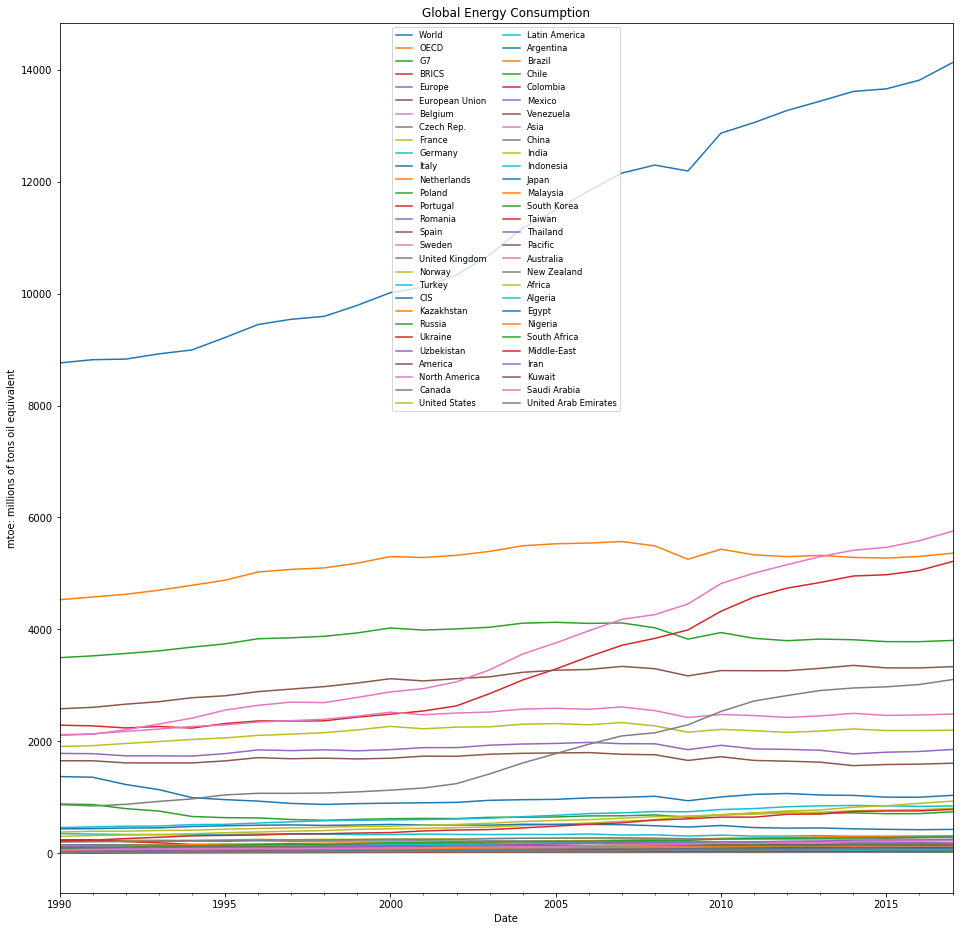

In [43]:
EnergyConsumption.plot(figsize= (16,16), title= "Global Energy Consumption")
plt.legend(loc='upper center', fontsize='small', ncol=2)
plt.ylabel('mtoe: millions of tons oil equivalent');

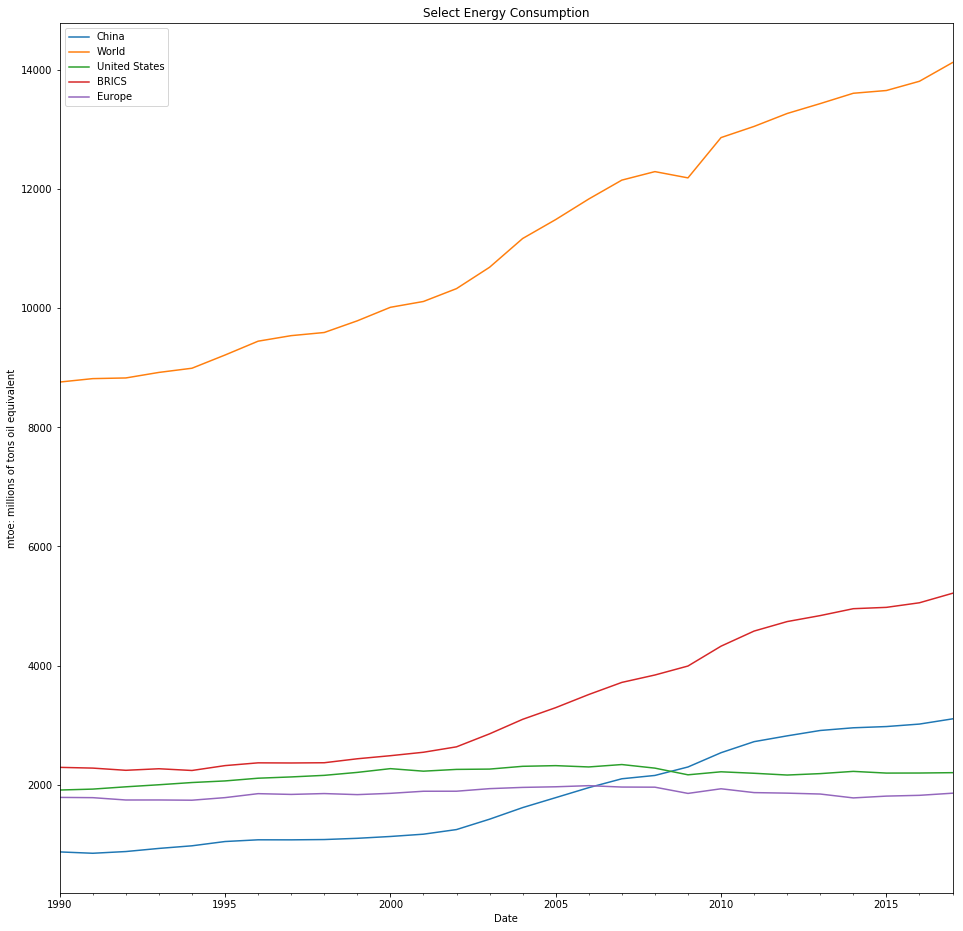

In [55]:
EnergyConsumption["China"].plot(figsize= (16,16),legend= True, title= "Select Energy Consumption")
EnergyConsumption["World"].plot(legend= True)
EnergyConsumption["United States"].plot(legend= True)
EnergyConsumption["BRICS"].plot(legend= True)
EnergyConsumption["Europe"].plot(legend= True)
plt.ylabel('mtoe: millions of tons oil equivalent');

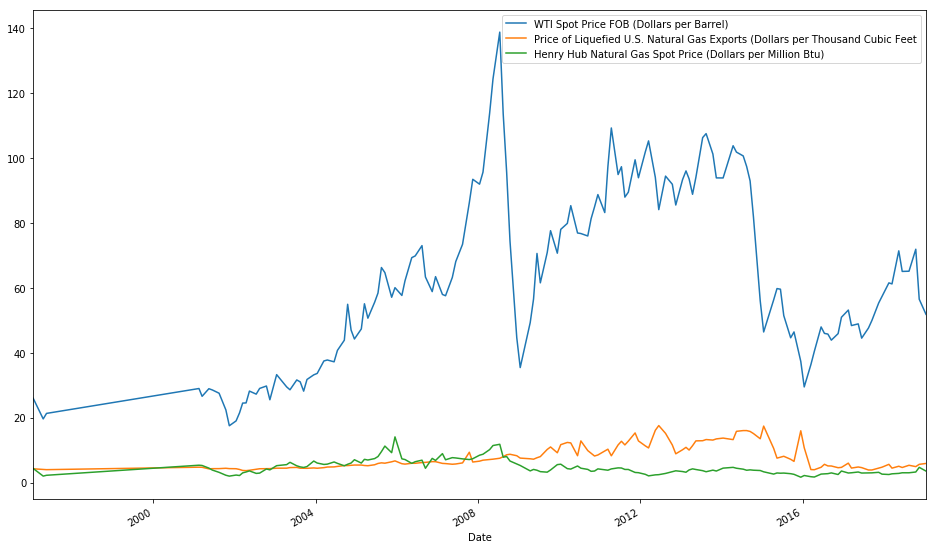

In [56]:
energyPrices.plot(figsize= (16,10))
plt.legend()
plt.show();

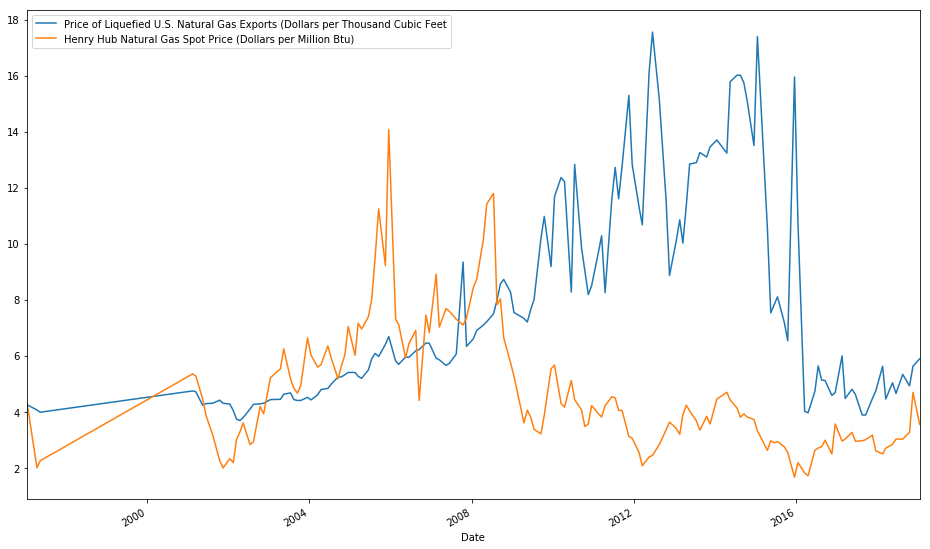

In [57]:
energyPrices['Price of Liquefied U.S. Natural Gas Exports (Dollars per Thousand Cubic Feet'].plot(figsize= (16,10))
energyPrices['Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'].plot()
plt.legend()
plt.show();

In [58]:
map_hooray = folium.Map(location=[31.4, 121.467],
                    zoom_start = 4, ) # Uses lat then lon. The bigger the zoom number, the closer in you get
map_hooray

In [59]:
asiaweather= pd.read_csv('AsiaWeather.csv')
nychouston = pd.read_csv('HoustonNYCweather.csv')

In [60]:
asiaweather.head()

STATION            NAME        DATE  TAVG  TMAX  TMIN  WT01  WT02  \
0  KSM00047108  SEOUL CITY, KS  1997-01-01  23.0  46.0   NaN   NaN   NaN   
1  KSM00047108  SEOUL CITY, KS  1997-01-02  17.0  23.0  12.0   NaN   NaN   
2  KSM00047108  SEOUL CITY, KS  1997-01-03  20.0  27.0  14.0   NaN   NaN   
3  KSM00047108  SEOUL CITY, KS  1997-01-04  27.0  34.0  14.0   NaN   NaN   
4  KSM00047108  SEOUL CITY, KS  1997-01-05  26.0  35.0   NaN   NaN   NaN   

   WT03  WT04  WT05  WT08  WT11  WT13  WT14  WT16  WT18  WT21  WV20  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [61]:
nychouston.head()

STATION                              NAME        DATE  TAVG  TMAX  TMIN
0  USW00094789  JFK INTERNATIONAL AIRPORT, NY US  1997-01-01   NaN  28.0  12.0
1  USW00094789  JFK INTERNATIONAL AIRPORT, NY US  1997-01-02   NaN  42.0  28.0
2  USW00094789  JFK INTERNATIONAL AIRPORT, NY US  1997-01-03   NaN  59.0  42.0
3  USW00094789  JFK INTERNATIONAL AIRPORT, NY US  1997-01-04   NaN  52.0  41.0
4  USW00094789  JFK INTERNATIONAL AIRPORT, NY US  1997-01-05   NaN  53.0  45.0

In [62]:
asiaweather['DATE'].dtype

dtype('O')

In [63]:
asiaweather['DATE']= pd.to_datetime(asiaweather['DATE'])

In [64]:
nychouston['DATE']= pd.to_datetime(nychouston['DATE'])

In [65]:
asiaweather.set_index('DATE', inplace=True)

In [66]:
nychouston.set_index('DATE', inplace=True)

In [67]:
asiaweather['TAVG'].isnull().sum()

2519

In [68]:
nychouston['TAVG'].isnull().sum()

6519

In [69]:
asiaweather = asiaweather[['STATION','NAME','TAVG','TMAX','TMIN']]
nychouston = nychouston[['STATION','NAME','TAVG','TMAX','TMIN']]

In [70]:
asiaweather['TAVG'].fillna(((asiaweather['TMAX']+asiaweather['TMIN'])/2), inplace= True)

In [71]:
nychouston['TAVG'].fillna(((nychouston['TMAX']+nychouston['TMIN'])/2), inplace= True)

In [72]:
asiaweather['TAVG'].isna().sum()

188

In [73]:
nychouston['TAVG'].isna().sum()

0

In [74]:
asiaweather.head()

STATION            NAME  TAVG  TMAX  TMIN
DATE                                                     
1997-01-01  KSM00047108  SEOUL CITY, KS  23.0  46.0   NaN
1997-01-02  KSM00047108  SEOUL CITY, KS  17.0  23.0  12.0
1997-01-03  KSM00047108  SEOUL CITY, KS  20.0  27.0  14.0
1997-01-04  KSM00047108  SEOUL CITY, KS  27.0  34.0  14.0
1997-01-05  KSM00047108  SEOUL CITY, KS  26.0  35.0   NaN

In [75]:
asiaweather.sort_index(inplace=True)
nychouston.sort_index(inplace=True)

In [76]:
asiaweather['TAVG'].dropna(inplace= True)

In [77]:
asiaweather.head()

STATION            NAME  TAVG  TMAX  TMIN
DATE                                                     
1997-01-01  KSM00047108  SEOUL CITY, KS  23.0  46.0   NaN
1997-01-01  JAW00043323    YOKOSUKA, JA  54.0  65.0  43.0
1997-01-01  JA000047670    YOKOHAMA, JA  57.0  62.0  43.0
1997-01-01  JA000047780        NARA, JA  53.0  65.0  37.0
1997-01-01  JAM00047772       OSAKA, JA  57.0  65.0  43.0

In [78]:
asiaweather= asiaweather[['TAVG', 'STATION', 'NAME']]
nychouston= nychouston[['TAVG', 'STATION', 'NAME']]

In [79]:
nychouston.head()

TAVG      STATION                                     NAME
DATE                                                                  
1997-01-01  20.0  USW00094789         JFK INTERNATIONAL AIRPORT, NY US
1997-01-01  61.0  USW00012960  HOUSTON INTERCONTINENTAL AIRPORT, TX US
1997-01-02  35.0  USW00094789         JFK INTERNATIONAL AIRPORT, NY US
1997-01-02  70.0  USW00012960  HOUSTON INTERCONTINENTAL AIRPORT, TX US
1997-01-03  50.5  USW00094789         JFK INTERNATIONAL AIRPORT, NY US

In [80]:
weatherdata= asiaweather.append(nychouston)

In [81]:
citylist = list(weatherdata['NAME'].unique())
print(citylist)

['SEOUL CITY, KS', 'YOKOSUKA, JA', 'YOKOHAMA, JA', 'NARA, JA', 'OSAKA, JA', 'BEIJING, CH', 'INCHEON, KS', 'SHENYANG, CH', 'SHANGHAI, CH', 'CHIBA, JA', 'KOBE, JA', 'SHANGHAI HONGQIAO, CH', 'TOKYO, JA', 'KANSAI INTERNATIONA, JA', 'KYOTO, JA', 'JFK INTERNATIONAL AIRPORT, NY US', 'HOUSTON INTERCONTINENTAL AIRPORT, TX US']


In [82]:
seouldaily = weatherdata[weatherdata['NAME'] =='SEOUL CITY, KS']
houstondaily= weatherdata[weatherdata['NAME']== 'HOUSTON INTERCONTINENTAL AIRPORT, TX US']
nycdaily= weatherdata[weatherdata['NAME']== 'JFK INTERNATIONAL AIRPORT, NY US']
shanghaidaily= weatherdata[weatherdata['NAME']== 'SHANGHAI, CH']
osakadaily= weatherdata[weatherdata['NAME']== 'OSAKA, JA']
tokyodaily= weatherdata[weatherdata['NAME']== 'TOKYO, JA']
beijingdaily= weatherdata[weatherdata['NAME']== 'BEIJING, CH']

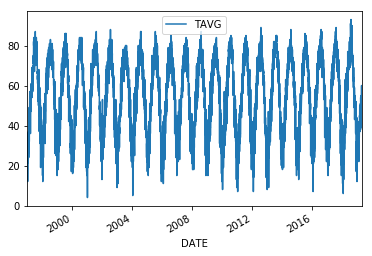

In [83]:
seouldaily.plot()

In [84]:
weatherdata.sort_index(inplace= True)

In [85]:
weatherdata.head()

TAVG      STATION                                     NAME
DATE                                                                  
1997-01-01  23.0  KSM00047108                           SEOUL CITY, KS
1997-01-01  61.0  USW00012960  HOUSTON INTERCONTINENTAL AIRPORT, TX US
1997-01-01  54.0  JA000047759                                KYOTO, JA
1997-01-01  56.0  JA000047772                  KANSAI INTERNATIONA, JA
1997-01-01  56.0  JA000047662                                TOKYO, JA

In [86]:
len(citylist)

17

In [87]:
seoul = weatherdata.loc[weatherdata['NAME'] == 'SEOUL CITY, KS'].resample('QS-Oct').mean()
nyc = weatherdata.loc[weatherdata['NAME'] == 'JFK INTERNATIONAL AIRPORT, NY US'].resample('QS-Oct').mean()
houston = weatherdata.loc[weatherdata['NAME'] == 'HOUSTON INTERCONTINENTAL AIRPORT, TX US'].resample('QS-Oct').mean()
kyoto= weatherdata.loc[weatherdata['NAME'] == 'KYOTO, JA'].resample('QS-Oct').mean()
tokyo= weatherdata.loc[weatherdata['NAME'] == 'TOKYO, JA'].resample('QS-Oct').mean()
kansai = weatherdata.loc[weatherdata['NAME'] == 'KANSAI INTERNATIONA, JA'].resample('QS-Oct').mean()
osaka = weatherdata.loc[weatherdata['NAME'] == 'OSAKA, JA'].resample('QS-Oct').mean()
yokohama = weatherdata.loc[weatherdata['NAME'] == 'YOKOHAMA, JA'].resample('QS-Oct').mean()
yokosuka = weatherdata.loc[weatherdata['NAME'] == 'YOKOSUKA, JA'].resample('QS-Oct').mean()
nara = weatherdata.loc[weatherdata['NAME'] == 'NARA, JA'].resample('QS-Oct').mean()
hongqiao = weatherdata.loc[weatherdata['NAME'] =='SHANGHAI HONGQIAO, CH'].resample('QS-Oct').mean()
kobe = weatherdata.loc[weatherdata['NAME'] =='KOBE, JA'].resample('QS-Oct').mean()
incheon= weatherdata.loc[weatherdata['NAME']=='INCHEON, KS'].resample('QS-Oct').mean()
beijing = weatherdata.loc[weatherdata['NAME']=='BEIJING, CH'].resample('QS-Oct').mean()
chiba= weatherdata.loc[weatherdata['NAME']=='CHIBA, JA'].resample('QS-Oct').mean()
shenyang= weatherdata.loc[weatherdata['NAME']=='SHENYANG, CH'].resample('QS-Oct').mean()
shanghai = weatherdata.loc[weatherdata['NAME']=='SHANGHAI, CH'].resample('QS-Oct').mean()

In [88]:
citylist = list(weatherdata['NAME'].unique())

In [89]:
globalweatherseasons= pd.concat([seoul,nyc,houston, kyoto, tokyo, kansai, osaka, yokohama, yokosuka, nara, hongqiao,kobe, incheon, beijing,chiba,shenyang, shanghai] ,sort= True , axis= 1)


In [90]:
globalweatherseasons.shape

(90, 17)

In [91]:
globalweatherseasons.columns = ['seoul','nyc','houston', 'kyoto', 'tokyo', 'kansai', 'osaka', 'yokohama', 'yokosuka', 'nara', 'hongqiao','kobe', 'incheon', 'beijing','chiba','shenyang', 'shanghai']




In [92]:
globalweatherseasons['globalavg']= globalweatherseasons.mean(axis=1)

In [93]:
globalweatherseasons.head()

seoul        nyc    houston      kyoto      tokyo     kansai  \
DATE                                                                           
1997-01-01  34.555556  37.872222  57.172222  43.255556  46.677778  45.533333   
1997-04-01  63.934066  58.851648  72.296703  66.296703  66.340659  65.945055   
1997-07-01  75.847826  71.978261  81.771739  78.858696  77.858696  79.032609   
1997-10-01  46.293478  46.793478  58.239130  54.565217  57.195652  57.989130   
1998-01-01  37.666667  40.683333  57.483333  44.944444  45.544444  46.533333   

                osaka   yokohama   yokosuka       nara   hongqiao       kobe  \
DATE                                                                           
1997-01-01  45.244444  46.133333  48.450000  41.788889  45.222222  44.255556   
1997-04-01  67.340659  65.076923  66.928571  64.494505  70.373626  66.098901   
1997-07-01  79.630435  76.663043  76.663043  76.554348  79.565217  77.902174   
1997-10-01  56.706522  56.489130  58.836957  52.347826  57.032609  56.065217   
1998-01-01  46.600000  45.044444  47.461111  43.233333  45.477778  45.755556   

              incheon    beijing      chiba   shenyang   shanghai  globalavg  
DATE                                                                          
1997-01-01  33.222222  35.777778  46.333333  21.833333  44.477778  42.223856  
1997-04-01  61.219780  67.461538  65.604396  62.461538  69.571429  65.899806  
1997-07-01  74.576087  76.119565  76.902174  73.423913  79.097826  77.202685  
1997-10-01  46.054348  42.793478  56.978261  34.271739  56.815217  52.674552  
1998-01-01  36.655556  35.600000  44.922222  25.533333  45.066667  43.188562

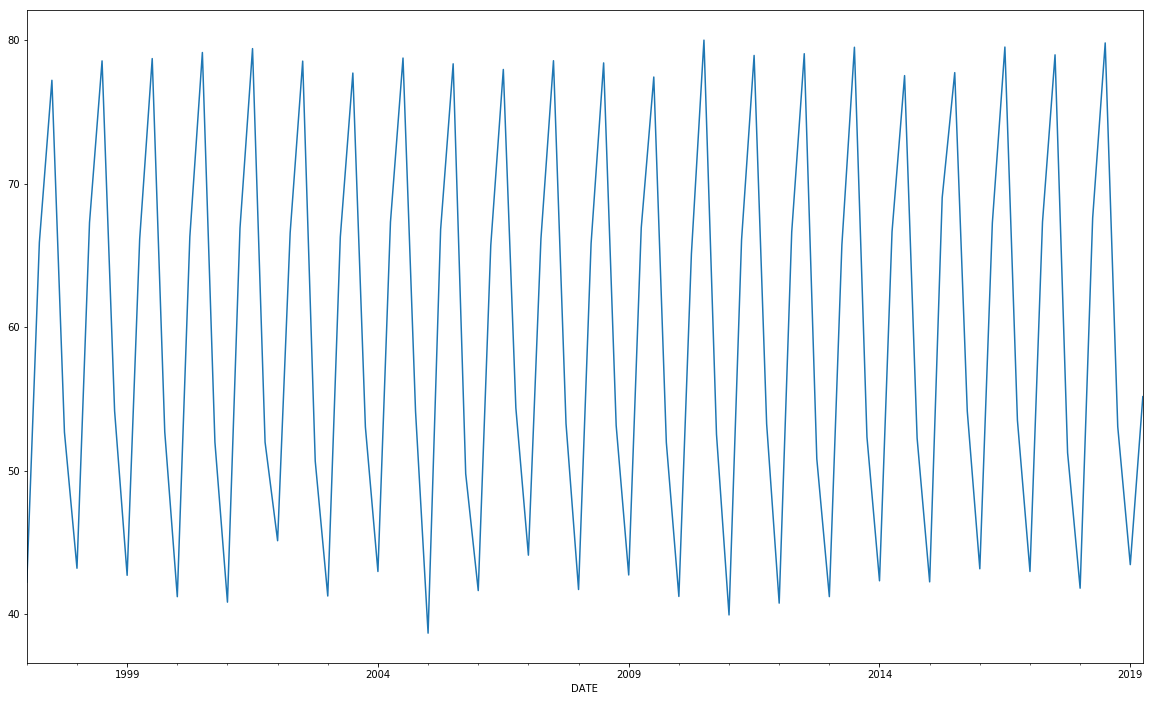

In [94]:
globalweatherseasons['globalavg'].plot(figsize=(20,12));

In [95]:
globalweatherseasons['globalmeanrolled']= np.zeros(globalweatherseasons['globalavg'].shape)
for i in range(len(globalweatherseasons['globalavg'])):
        globalweatherseasons['globalmeanrolled'][i] = globalweatherseasons['globalavg'][:i+1].mean()

In [96]:
globalavgtemp= globalweatherseasons['globalavg']

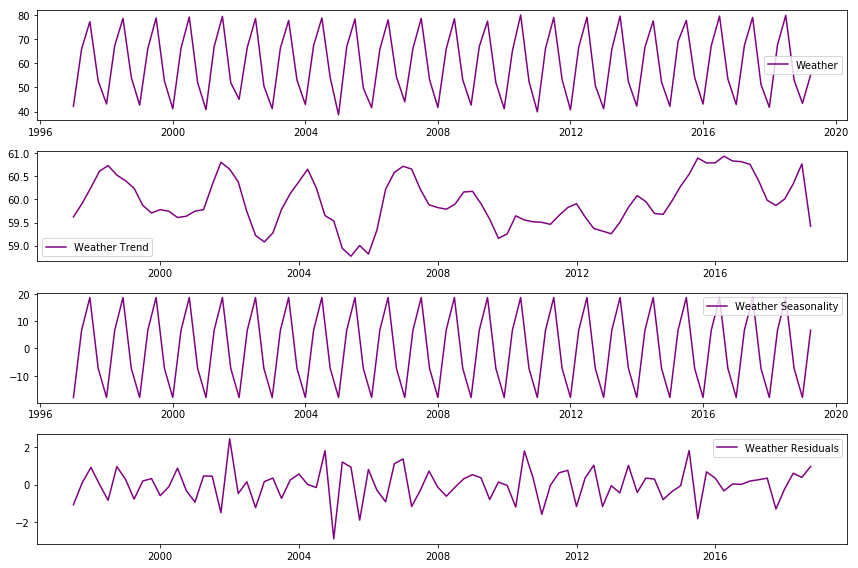

In [97]:
# import seasonal_decompose
decomposition = seasonal_decompose(globalavgtemp, model= 'additive')

# Gather the trend, seasonality and noise of decomposed object
weathertrend = decomposition.trend
weatherseasonal = decomposition.seasonal
weatherresidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(globalavgtemp, label='Weather', color="purple")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(weathertrend, label='Weather Trend', color="purple")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(weatherseasonal,label='Weather Seasonality', color="purple")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(weatherresidual, label='Weather Residuals', color="purple")
plt.legend(loc='best')
plt.tight_layout()

In [98]:
weatherresidual.dropna(inplace= True)

In [99]:
adfuller(weatherresidual)

(-5.9348225601587465,
 2.3343455824052357e-07,
 12,
 73,
 {'1%': -3.5232835753964475,
  '5%': -2.902030597326081,
  '10%': -2.5883710883843123},
 144.76914011998656)

## More Weather 

In [100]:
nycwinters, nycsummers, nycsprings, nycfalls = nyc.loc[nyc.index.month == 1], nyc.loc[nyc.index.month == 7], nyc.loc[nyc.index.month == 4], nyc.loc[nyc.index.month == 4]
houstonwinters, houstonsummers, houstonsprings, houstonfalls = houston.loc[houston.index.month == 1], houston.loc[houston.index.month == 7], houston.loc[houston.index.month == 4], houston.loc[houston.index.month == 4]
shanghaiwinters, shanghaisummers, shanghaisprings, shanghaifalls = shanghai.loc[houston.index.month == 1], shanghai.loc[houston.index.month == 7], shanghai.loc[houston.index.month == 4], shanghai.loc[houston.index.month == 4]


In [101]:
houstonsummers

TAVG
DATE                 
1997-07-01  81.771739
1998-07-01  84.760870
1999-07-01  82.913043
2000-07-01  83.391304
2001-07-01  81.695652
2002-07-01  82.934783
2003-07-01  82.163043
2004-07-01  83.070652
2005-07-01  84.250000
2006-07-01  82.576087
2007-07-01  83.157609
2008-07-01  82.375000
2009-07-01  84.250000
2010-07-01  84.418478
2011-07-01  86.820652
2012-07-01  82.945652
2013-07-01  82.760870
2014-07-01  81.673913
2015-07-01  82.641304
2016-07-01  83.358696
2017-07-01  81.956522
2018-07-01  82.826087

In [102]:
nycwinters['TAVG'][:3].mean()

38.66296296296296

In [103]:
houstonlist = [houstonwinters, houstonsummers, houstonsprings, houstonfalls]

for h in houstonlist:
    h['meanrolled']= np.zeros(h['TAVG'].shape)
    for i in range(len(h['TAVG'])):
        h['meanrolled'][i]= h['TAVG'][:i+1].mean()

In [104]:
nyclist = [nycwinters, nycsummers, nycsprings, nycfalls]
shanghai = [shanghaiwinters, shanghaisummers, shanghaisprings, shanghaifalls]


#function to create a dynamic mean in dataframe

def dynamicmean(thelist):
    for h in thelist:
        h['meanrolled']= np.zeros(h['TAVG'].shape)
        for i in range(len(h['TAVG'])):
            h['meanrolled'][i]= h['TAVG'][:i+1].mean()

dynamicmean(shanghai)

In [105]:
nycwinters['meanrolled']= np.zeros(nycwinters['TAVG'].shape)

In [106]:
nycsummers['meanrolled']= np.zeros(nycsummers['TAVG'].shape)

In [107]:
for i in range(len(nycsummers['TAVG'])):
    nycsummers['meanrolled'][i]= nycsummers['TAVG'][:i+1].mean()

In [108]:
for i in range(len(nycwinters['TAVG'])):
    nycwinters['meanrolled'][i]= nycwinters['TAVG'][:i+1].mean()

In [109]:
houstonsummers['hotterthanaveragesummer']=  houstonsummers['TAVG']> houstonsummers['meanrolled']

In [110]:
houstonsummers

TAVG  meanrolled  hotterthanaveragesummer
DATE                                                      
1997-07-01  81.771739   81.771739                    False
1998-07-01  84.760870   83.266304                     True
1999-07-01  82.913043   83.148551                    False
2000-07-01  83.391304   83.209239                     True
2001-07-01  81.695652   82.906522                    False
2002-07-01  82.934783   82.911232                     True
2003-07-01  82.163043   82.804348                    False
2004-07-01  83.070652   82.837636                     True
2005-07-01  84.250000   82.994565                     True
2006-07-01  82.576087   82.952717                    False
2007-07-01  83.157609   82.971344                     True
2008-07-01  82.375000   82.921649                    False
2009-07-01  84.250000   83.023829                     True
2010-07-01  84.418478   83.123447                     True
2011-07-01  86.820652   83.369928                     True
2012-07-01  82.945652   83.343410                    False
2013-07-01  82.760870   83.309143                    False
2014-07-01  81.673913   83.218297                    False
2015-07-01  82.641304   83.187929                    False
2016-07-01  83.358696   83.196467                     True
2017-07-01  81.956522   83.137422                    False
2018-07-01  82.826087   83.123271                    False

In [111]:
nycsummers

TAVG  meanrolled
DATE                             
1997-07-01  71.978261   71.978261
1998-07-01  74.152174   73.065217
1999-07-01  74.380435   73.503623
2000-07-01  70.869565   72.845109
2001-07-01  72.554348   72.786957
2002-07-01  74.760870   73.115942
2003-07-01  73.961957   73.236801
2004-07-01  72.706522   73.170516
2005-07-01  75.565217   73.436594
2006-07-01  73.375000   73.430435
2007-07-01  72.538043   73.349308
2008-07-01  73.456522   73.358243
2009-07-01  72.402174   73.284699
2010-07-01  75.858696   73.468556
2011-07-01  75.070652   73.575362
2012-07-01  74.826087   73.653533
2013-07-01  73.228261   73.628517
2014-07-01  72.815217   73.583333
2015-07-01  76.228261   73.722540
2016-07-01  75.989130   73.835870
2017-07-01  73.456522   73.817805
2018-07-01  74.597826   73.853261

# ARIMA Decomposition

## Crude WTI

In [112]:
energyPrices.columns = ['WTI', 'LNG', 'NAT']

In [113]:
crude= energyPrices['WTI'].astype('float64')

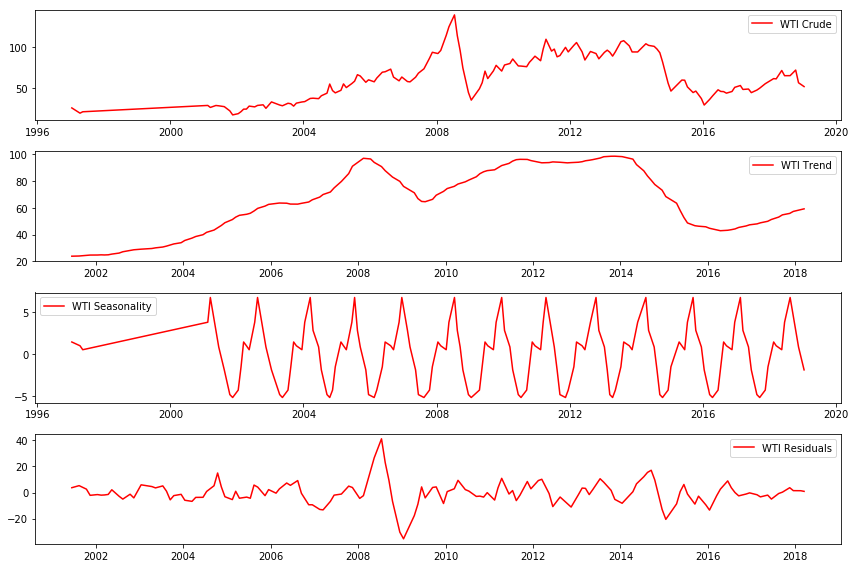

In [114]:
# import seasonal_decompose
decomposition = seasonal_decompose(crude, model= 'additive', freq=12)

# Gather the trend, seasonality and noise of decomposed object
crudetrend = decomposition.trend
crudeseasonal = decomposition.seasonal
cruderesidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(crude, label='WTI Crude', color="red")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(crudetrend, label='WTI Trend', color="red")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(crudeseasonal,label='WTI Seasonality', color="red")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(cruderesidual, label='WTI Residuals', color="red")
plt.legend(loc='best')
plt.tight_layout()

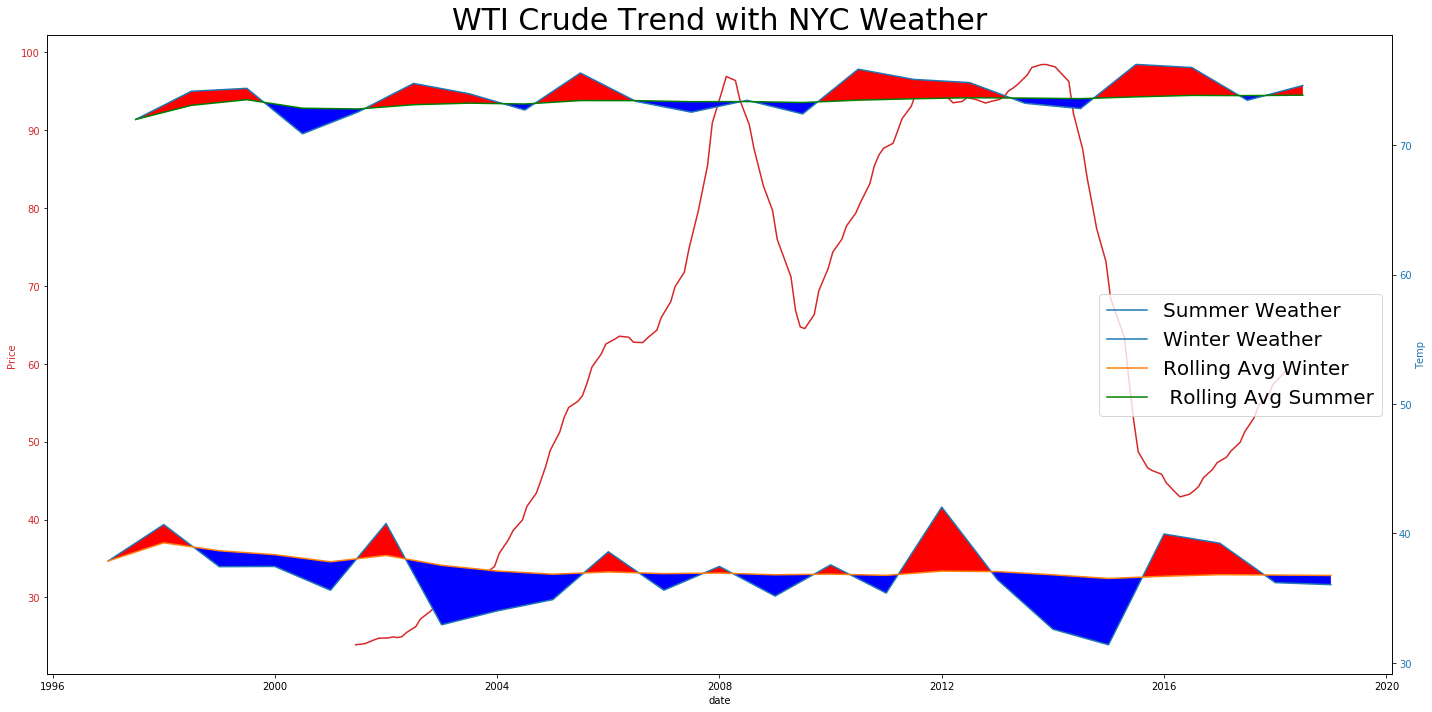

In [115]:
# crudetrend.plot(figsize= (16,10))
# crude.plot()
# houstonwinters['TAVG'].plot()
# houstonwinters['meanrolled'].plot()



fig, ax1 = plt.subplots(figsize=(20, 10))


color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('Price', color=color)
ax1.plot(crudetrend, color=color, label= 'WTI Crude Trend')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Temp', color=color)  # we already handled the x-label with ax1
ax2.plot(nycsummers['TAVG'], color=color, label= "Summer Weather")
ax2.plot(nycwinters['TAVG'], label= "Winter Weather")
ax2.fill_between(nycwinters.index, nycwinters['meanrolled'] ,nycwinters['TAVG'], where= nycwinters['TAVG'] >= nycwinters['meanrolled'],
                 facecolor='red', interpolate=True)
ax2.fill_between(nycwinters.index, nycwinters['meanrolled'] ,nycwinters['TAVG'], where= nycwinters['TAVG'] <= nycwinters['meanrolled'],
                 facecolor='blue', interpolate=True)
ax2.fill_between(nycsummers.index, nycsummers['meanrolled'] ,nycsummers['TAVG'], where= nycsummers['TAVG'] >= nycsummers['meanrolled'],
                 facecolor='red', interpolate=True)
ax2.fill_between(nycsummers.index, nycsummers['meanrolled'] ,nycsummers['TAVG'], where= nycsummers['TAVG'] <= nycsummers['meanrolled'],
                 facecolor='blue', interpolate=True)
ax2.plot(nycwinters['meanrolled'], label= "Rolling Avg Winter")
ax2.plot(nycsummers['meanrolled'], color='green' , label = " Rolling Avg Summer")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('WTI Crude Trend with NYC Weather', fontsize= 30)
plt.tight_layout()
plt.legend(fontsize= 20)
plt.show();



## HH Nat Gas

In [116]:
energyPrices.head()

WTI   LNG   NAT
Date                         
1997-01-15  25.95  4.25  4.34
1997-04-15   19.6  4.06     2
1997-05-15   21.3  3.98  2.25
2001-02-15  28.96  4.74  5.35
2001-03-15  26.56  4.71  5.27

In [117]:
gas = energyPrices['NAT'].astype('float64')

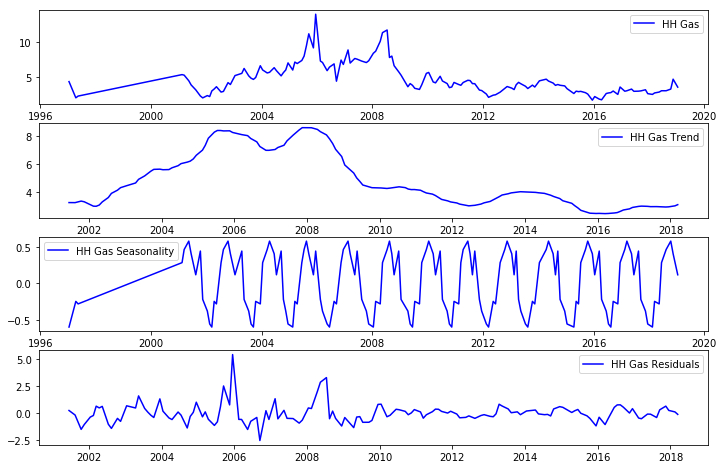

In [118]:
# import seasonal_decompose
decomposition = seasonal_decompose(gas, model= 'additive', freq=12)

# Gather the trend, seasonality and noise of decomposed object
gastrend = decomposition.trend
gasseasonal = decomposition.seasonal
gasresidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(gas, label='HH Gas', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(gastrend, label='HH Gas Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(gasseasonal,label='HH Gas Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(gasresidual, label='HH Gas Residuals', color="blue")
plt.legend(loc='best');

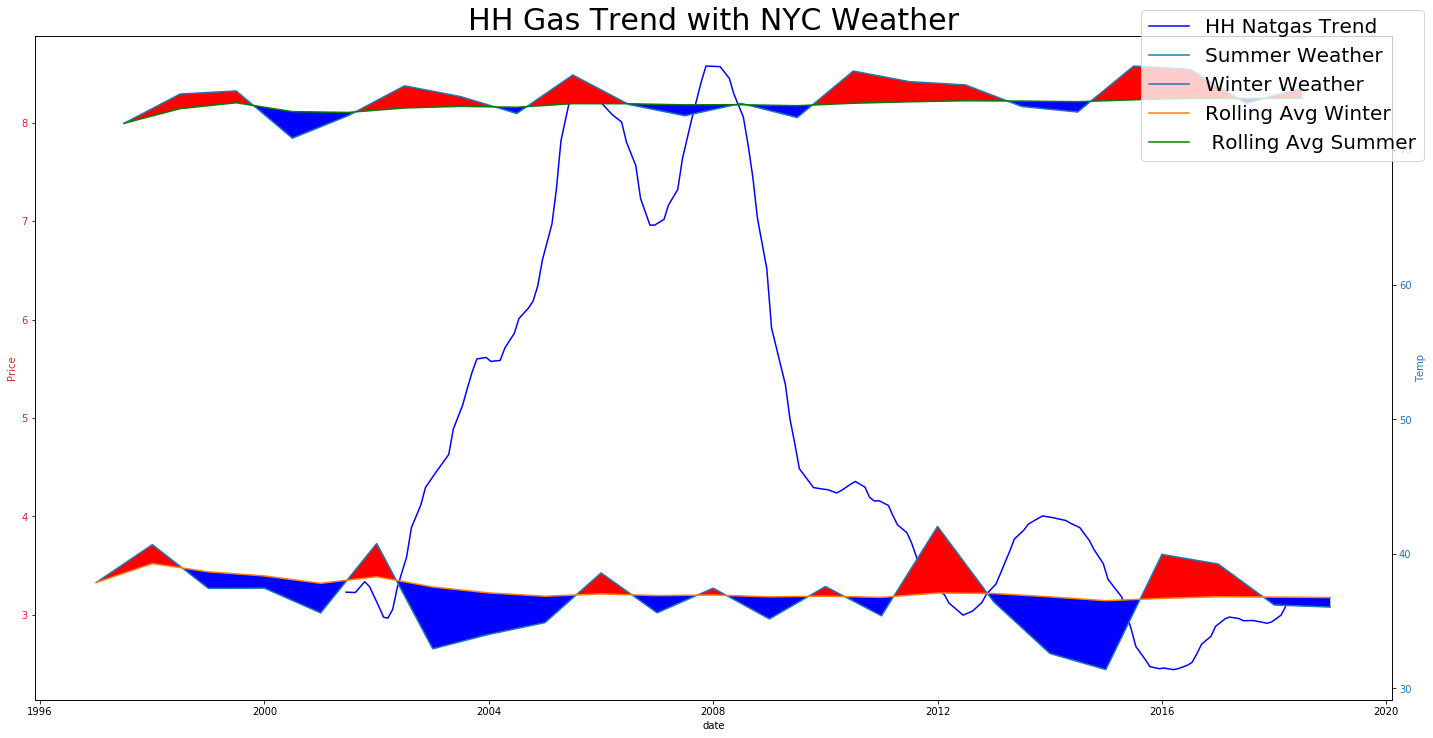

In [119]:
fig, ax1 = plt.subplots(figsize=(20, 10))


color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('Price', color=color)
ax1.plot(gastrend, color= 'blue', label= 'HH Natgas Trend')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Temp', color=color)  # we already handled the x-label with ax1
ax2.plot(nycsummers['TAVG'], color=color, label= "Summer Weather")
ax2.plot(nycwinters['TAVG'], label= "Winter Weather")
ax2.plot(nycwinters['meanrolled'], label= "Rolling Avg Winter")
ax2.plot(nycsummers['meanrolled'], color='green' , label = " Rolling Avg Summer")
ax2.fill_between(nycwinters.index, nycwinters['meanrolled'] ,nycwinters['TAVG'], where= nycwinters['TAVG'] >= nycwinters['meanrolled'],
                 facecolor='red', interpolate=True)
ax2.fill_between(nycwinters.index, nycwinters['meanrolled'] ,nycwinters['TAVG'], where= nycwinters['TAVG'] <= nycwinters['meanrolled'],
                 facecolor='blue', interpolate=True)
ax2.fill_between(nycsummers.index, nycsummers['meanrolled'] ,nycsummers['TAVG'], where= nycsummers['TAVG'] >= nycsummers['meanrolled'],
                 facecolor='red', interpolate=True)
ax2.fill_between(nycsummers.index, nycsummers['meanrolled'] ,nycsummers['TAVG'], where= nycsummers['TAVG'] <= nycsummers['meanrolled'],
                 facecolor='blue', interpolate=True)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(fontsize= 20)
plt.title('HH Gas Trend with NYC Weather', fontsize =30)
plt.show();


# LNG 

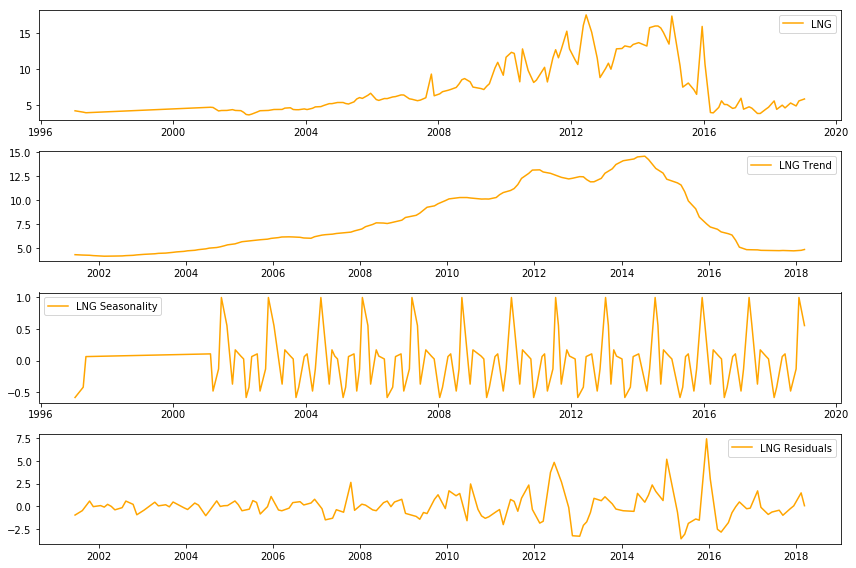

In [120]:
# import seasonal_decompose

lng = energyPrices['LNG'].astype('float64')
decomposition = seasonal_decompose(lng, model= 'additive', freq=12)

# Gather the trend, seasonality and noise of decomposed object
lngtrend = decomposition.trend
lngseasonal = decomposition.seasonal
lngresidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(lng, label='LNG', color="orange")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(lngtrend, label='LNG Trend', color="orange")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(lngseasonal,label='LNG Seasonality', color="orange")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(lngresidual, label='LNG Residuals', color="orange")
plt.legend(loc='best')
plt.tight_layout()

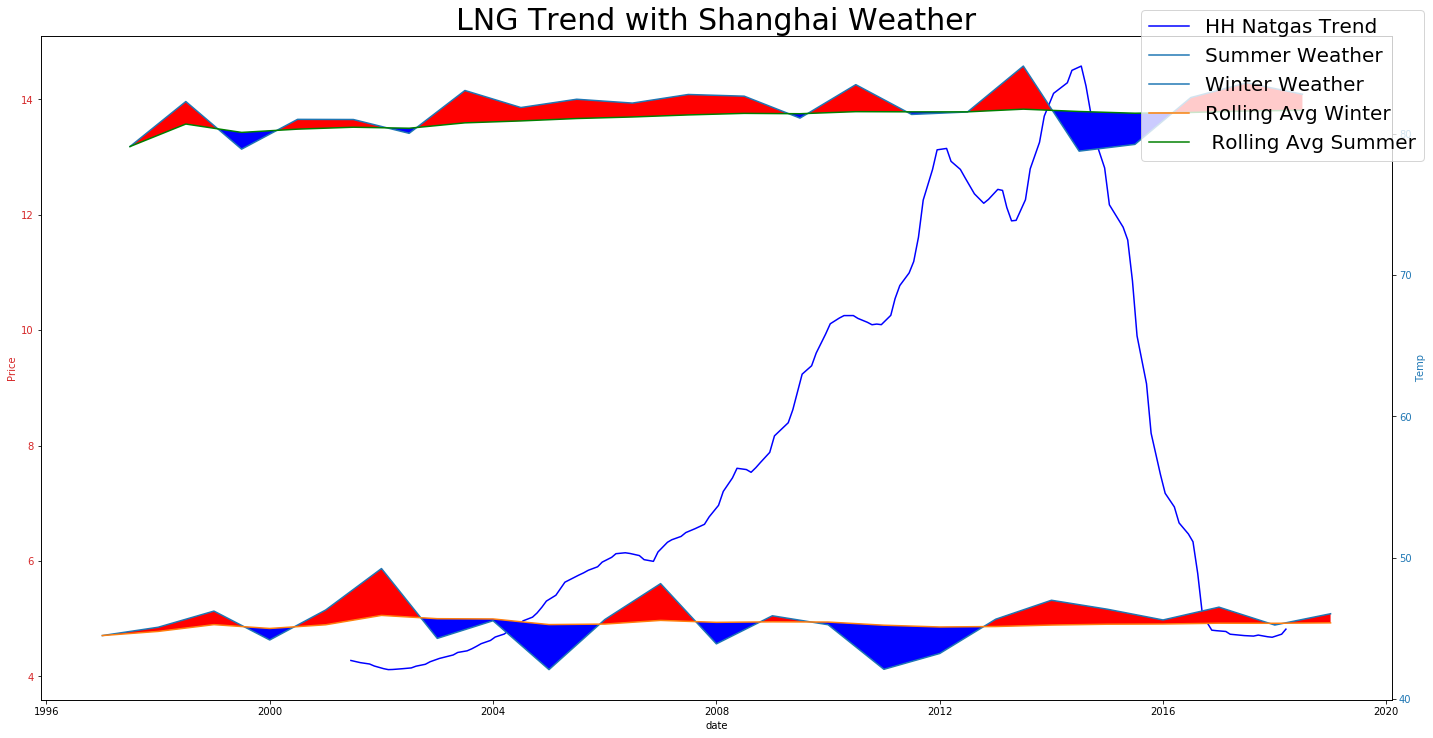

In [121]:
fig, ax1 = plt.subplots(figsize=(20, 10))


color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('Price', color=color)
ax1.plot(lngtrend, color= 'blue', label= 'HH Natgas Trend')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Temp', color=color)  # we already handled the x-label with ax1
ax2.plot(shanghaisummers['TAVG'], color=color, label= "Summer Weather")
ax2.plot(shanghaiwinters['TAVG'], label= "Winter Weather")
ax2.plot(shanghaiwinters['meanrolled'], label= "Rolling Avg Winter")
ax2.plot(shanghaisummers['meanrolled'], color='green' , label = " Rolling Avg Summer")
ax2.fill_between(shanghaiwinters.index, shanghaiwinters['meanrolled'] ,shanghaiwinters['TAVG'], where= shanghaiwinters['TAVG'] >= shanghaiwinters['meanrolled'],
                 facecolor='red', interpolate=True)
ax2.fill_between(shanghaiwinters.index, shanghaiwinters['meanrolled'] ,shanghaiwinters['TAVG'], where= shanghaiwinters['TAVG'] <= shanghaiwinters['meanrolled'],
                 facecolor='blue', interpolate=True)
ax2.fill_between(shanghaisummers.index, shanghaisummers['meanrolled'] ,shanghaisummers['TAVG'], where= shanghaisummers['TAVG'] >= shanghaisummers['meanrolled'],
                 facecolor='red', interpolate=True)
ax2.fill_between(shanghaisummers.index, shanghaisummers['meanrolled'] ,shanghaisummers['TAVG'], where= shanghaisummers['TAVG'] <= shanghaisummers['meanrolled'],
                 facecolor='blue', interpolate=True)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(fontsize= 20)
plt.title('LNG Trend with Shanghai Weather', fontsize =30)
plt.show();

>> ### No real noticeable relationships here

In [122]:
lngresidual.dropna(inplace= True)

In [123]:
energyPrices.head()

WTI   LNG   NAT
Date                         
1997-01-15  25.95  4.25  4.34
1997-04-15   19.6  4.06     2
1997-05-15   21.3  3.98  2.25
2001-02-15  28.96  4.74  5.35
2001-03-15  26.56  4.71  5.27

# Strong indication that LNG prices are caused by WTI Crude

In [124]:
grangercausalitytests(energyPrices[['LNG','WTI']], 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.1582 , p=0.0000  , df_denom=148, df_num=1
ssr based chi2 test:   chi2=19.5465 , p=0.0000  , df=1
likelihood ratio test: chi2=18.3810 , p=0.0000  , df=1
parameter F test:         F=19.1582 , p=0.0000  , df_denom=148, df_num=1


{1: ({'ssr_ftest': (19.158173855283717, 2.261139337635588e-05, 148.0, 1),
   'ssr_chi2test': (19.546515217215145, 9.817966608076798e-06, 1),
   'lrtest': (18.380964122860632, 1.808557998663807e-05, 1),
   'params_ftest': (19.158173855283742, 2.2611393376355444e-05, 148.0, 1.0)},
   array([[0., 1., 0.]])])}

# ARIMA

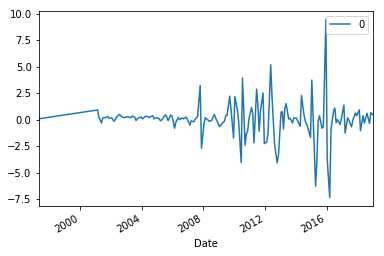

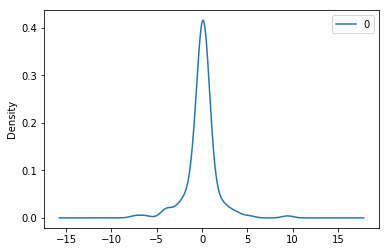

                0
count  151.000000
mean    -0.000012
std      1.696193
min     -7.351424
25%     -0.314737
50%      0.136261
75%      0.371401
max      9.438073


In [125]:
series= energyPrices['LNG'].astype('float64')
exog= energyPrices['WTI'].astype('float64')
model = ARIMA(endog=series, exog=exog, order=(1,1,0))
model_fit = model.fit(disp=0)
# print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [126]:
X1 = series.values
X2= exog.values
size = int(len(X1) * 0.9)
compsize= int(len(X1) * 0.1)
trainEndo, testEndo = X1[0:size], X1[size:]
trainExog, testExog = X2[0:size], X2[size:]

In [127]:
# define a new variable using train, but they're not the same variable
historyEndo = [x for x in trainEndo]
historyExog = [x for x in trainExog]

In [128]:
#instantiate empty list
predictions = list()

for t in range(len(testEndo)):
    model = ARIMA(endog=historyEndo, order=(0,0,0))
#     , exog=historyExog
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)
#     exog= np.array(testExog[t:t+1]
    yhat = output[0]
    predictions.append(yhat)
    obs = testEndo[t]
#     obsexog = testExog[t]
    historyEndo.append(obs)
#     historyExog.append(obsexog)

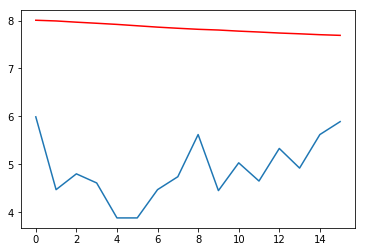

In [129]:
plt.plot(testEndo)
plt.plot(predictions, color='red')
plt.show()

In [130]:
error = mean_squared_error(testEndo, predictions)
print(error)

9.105782213426991


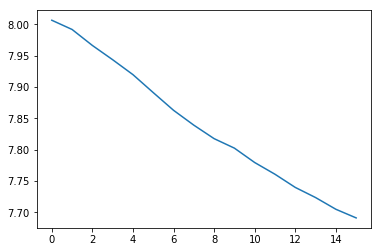

In [131]:
plt.plot(predictions)

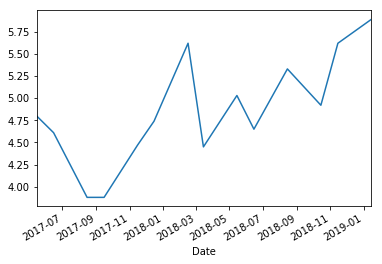

In [132]:
energyPrices['LNG'][-14:].plot()

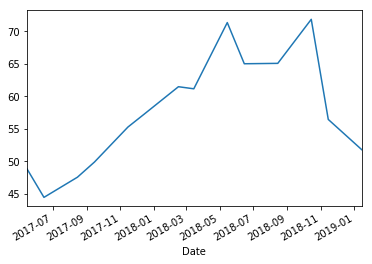

In [133]:
energyPrices['WTI'][-14:].plot()

In [134]:
energyandweather = energyPrices.join([beijingdaily], sort= True)

In [135]:
energyandweather.dropna(inplace= True)

In [136]:
energyandweather.head()

WTI   LNG   NAT  TAVG      STATION         NAME
Date                                                         
1997-01-15  25.95  4.25  4.34  22.0  CHM00054511  BEIJING, CH
1997-04-15   19.6  4.06     2  59.0  CHM00054511  BEIJING, CH
1997-05-15   21.3  3.98  2.25  78.0  CHM00054511  BEIJING, CH
2001-02-15  28.96  4.74  5.35  31.0  CHM00054511  BEIJING, CH
2001-03-15  26.56  4.71  5.27  47.0  CHM00054511  BEIJING, CH

# FB Prophet

In [137]:
ModelLNGWTI = proph(weekly_seasonality=True , daily_seasonality= False)

In [138]:
ModelLNGBeijing = proph(weekly_seasonality=True, daily_seasonality= False)

In [139]:
Model= proph(weekly_seasonality= True, daily_seasonality= False)

In [140]:
energyandweather.head()

WTI   LNG   NAT  TAVG      STATION         NAME
Date                                                         
1997-01-15  25.95  4.25  4.34  22.0  CHM00054511  BEIJING, CH
1997-04-15   19.6  4.06     2  59.0  CHM00054511  BEIJING, CH
1997-05-15   21.3  3.98  2.25  78.0  CHM00054511  BEIJING, CH
2001-02-15  28.96  4.74  5.35  31.0  CHM00054511  BEIJING, CH
2001-03-15  26.56  4.71  5.27  47.0  CHM00054511  BEIJING, CH

In [141]:
lngprophet = energyandweather.reset_index()

In [142]:
lngprophet.tail()

Date    WTI   LNG   NAT  TAVG      STATION         NAME
146 2018-06-15  65.01  4.65  3.02  76.0  CHM00054511  BEIJING, CH
147 2018-08-15  65.07  5.33  3.02  83.0  CHM00054511  BEIJING, CH
148 2018-10-15  71.84  4.92  3.26  56.0  CHM00054511  BEIJING, CH
149 2018-11-15  56.45  5.62  4.69  42.0  CHM00054511  BEIJING, CH
150 2019-01-15   51.8  5.89  3.54  22.0  CHM00054511  BEIJING, CH

In [143]:
lngprophet = lngprophet.rename(columns={'Date': 'ds',
                        'LNG' : 'y' , 'TAVG': 'BeijingTemp'})

In [144]:
lngprophet.head()

ds    WTI     y   NAT  BeijingTemp      STATION         NAME
0 1997-01-15  25.95  4.25  4.34         22.0  CHM00054511  BEIJING, CH
1 1997-04-15   19.6  4.06     2         59.0  CHM00054511  BEIJING, CH
2 1997-05-15   21.3  3.98  2.25         78.0  CHM00054511  BEIJING, CH
3 2001-02-15  28.96  4.74  5.35         31.0  CHM00054511  BEIJING, CH
4 2001-03-15  26.56  4.71  5.27         47.0  CHM00054511  BEIJING, CH

In [145]:
lngprophet.shape

(151, 7)

In [146]:
ModelLNGWTI.add_regressor('WTI')


In [147]:
ModelLNGBeijing.add_regressor('BeijingTemp')

In [148]:
Model.add_regressor('BeijingTemp')

In [149]:
Model.add_regressor('WTI')

In [150]:
ModelLNGWTI.fit(lngprophet)
ModelLNGBeijing.fit(lngprophet);

In [151]:
Model.fit(lngprophet)

In [875]:
future_dates1 = ModelLNGWTI.make_future_dataframe(periods=21, freq='M', include_history= False )

In [876]:
future_dates1['WTI']= lngprophet['WTI']
future_dates1['WTI'].fillna(lngprophet['WTI'].iloc[-2], inplace=True)


In [877]:
future_dates2 = ModelLNGBeijing.make_future_dataframe(periods=27, freq='M', include_history= False )
future_dates2['BeijingTemp']= lngprophet['BeijingTemp']
future_dates2['BeijingTemp'].fillna(lngprophet['BeijingTemp'].iloc[-1], inplace=True)

In [152]:
future_dates= Model.make_future_dataframe(periods=28, freq='M', include_history= False )

In [154]:
future_dates.head()

ds
0 2019-01-31
1 2019-02-28
2 2019-03-31
3 2019-04-30
4 2019-05-31

In [164]:
lngprophet

ds    WTI      y   NAT  BeijingTemp      STATION         NAME
0   1997-01-15  25.95   4.25  4.34         22.0  CHM00054511  BEIJING, CH
1   1997-04-15   19.6   4.06     2         59.0  CHM00054511  BEIJING, CH
2   1997-05-15   21.3   3.98  2.25         78.0  CHM00054511  BEIJING, CH
3   2001-02-15  28.96   4.74  5.35         31.0  CHM00054511  BEIJING, CH
4   2001-03-15  26.56   4.71  5.27         47.0  CHM00054511  BEIJING, CH
5   2001-05-15   28.9   4.23  4.46         74.0  CHM00054511  BEIJING, CH
6   2001-06-15  28.52   4.29  3.86         66.0  CHM00054511  BEIJING, CH
7   2001-08-15  27.51    4.3  3.15         80.0  CHM00054511  BEIJING, CH
8   2001-10-15  22.37   4.41  2.26         59.0  CHM00054511  BEIJING, CH
9   2001-11-15   17.5    4.3  1.99         40.0  CHM00054511  BEIJING, CH
10  2002-01-15  18.99   4.27  2.32         37.0  CHM00054511  BEIJING, CH
11  2002-02-15  21.47   4.04  2.18         36.0  CHM00054511  BEIJING, CH
12  2002-03-15  24.47   3.74  2.99         60.0  CHM00054511  BEIJING, CH
13  2002-04-15  24.53   3.68  3.27         62.0  CHM00054511  BEIJING, CH
14  2002-05-15  28.17   3.79   3.6         67.0  CHM00054511  BEIJING, CH
15  2002-07-15  27.23   4.09  2.83         88.0  CHM00054511  BEIJING, CH
16  2002-08-15  28.99   4.26  2.92         79.0  CHM00054511  BEIJING, CH
17  2002-10-15  29.73   4.28  4.19         54.0  CHM00054511  BEIJING, CH
18  2002-11-15   25.5    4.3  3.92         38.0  CHM00054511  BEIJING, CH
19  2003-01-15  33.23   4.43  5.21         26.0  CHM00054511  BEIJING, CH
20  2003-04-15  29.46   4.44  5.53         67.0  CHM00054511  BEIJING, CH
21  2003-05-15  28.57   4.62  6.24         64.0  CHM00054511  BEIJING, CH
22  2003-07-15   31.6   4.67  5.17         80.0  CHM00054511  BEIJING, CH
23  2003-08-15  31.01   4.43  4.83         74.0  CHM00054511  BEIJING, CH
24  2003-09-15  28.15    4.4  4.66         71.0  CHM00054511  BEIJING, CH
25  2003-10-15  31.74    4.4  4.93         56.0  CHM00054511  BEIJING, CH
26  2003-12-15  33.17   4.51  6.63         31.0  CHM00054511  BEIJING, CH
27  2004-01-15  33.61   4.42  6.02         26.0  CHM00054511  BEIJING, CH
28  2004-03-15  37.44    4.6  5.59         46.0  CHM00054511  BEIJING, CH
29  2004-04-15  37.74   4.79  5.68         71.0  CHM00054511  BEIJING, CH
..         ...    ...    ...   ...          ...          ...          ...
121 2015-06-15  59.53   7.82  2.89         80.0  CHM00054511  BEIJING, CH
122 2015-07-15   51.4    8.1  2.93         80.0  CHM00054511  BEIJING, CH
123 2015-09-15  44.58   7.17  2.74         67.0  CHM00054511  BEIJING, CH
124 2015-10-15  46.38   6.53  2.54         62.0  CHM00054511  BEIJING, CH
125 2015-12-15  37.32  15.95  1.66         33.0  CHM00054511  BEIJING, CH
126 2016-01-15  29.45  10.74  2.18         30.0  CHM00054511  BEIJING, CH
127 2016-03-15  36.32   4.01  1.81         44.0  CHM00054511  BEIJING, CH
128 2016-04-15   40.4   3.96  1.71         62.0  CHM00054511  BEIJING, CH
129 2016-06-15  47.92   4.72  2.62         74.0  CHM00054511  BEIJING, CH
130 2016-07-15  45.93   5.63   2.7         71.0  CHM00054511  BEIJING, CH
131 2016-08-15  45.72   5.13  2.75         74.0  CHM00054511  BEIJING, CH
132 2016-09-15  43.85   5.11  2.98         76.0  CHM00054511  BEIJING, CH
133 2016-11-15  45.86   4.58  2.49         40.0  CHM00054511  BEIJING, CH
134 2016-12-15   50.9   4.68  3.56         30.0  CHM00054511  BEIJING, CH
135 2017-02-15  53.11   5.99  2.95         36.0  CHM00054511  BEIJING, CH
136 2017-03-15  48.34   4.47  3.02         46.0  CHM00054511  BEIJING, CH
137 2017-05-15  48.86    4.8  3.26         72.0  CHM00054511  BEIJING, CH
138 2017-06-15  44.47   4.61  2.94         88.0  CHM00054511  BEIJING, CH
139 2017-08-15  47.57   3.88  2.96         81.0  CHM00054511  BEIJING, CH
140 2017-09-15   49.9   3.88     3         70.0  CHM00054511  BEIJING, CH
141 2017-11-15  55.28   4.47  3.16         32.0  CHM00054511  BEIJING, CH
142 2017-12-15  57.29   4.74   2.6         29.0  CHM00054511  BEIJING, CH
143 2018-02-15  

In [165]:
future_dates['WTI']= lngprophet['WTI']
future_dates['WTI'].fillna(lngprophet['WTI'].iloc[-2], inplace=True)
future_dates['BeijingTemp']= lngprophet['BeijingTemp']
future_dates['BeijingTemp'].fillna(lngprophet['BeijingTemp'].iloc[-1], inplace=True)

In [166]:
future_dates

ds    WTI  BeijingTemp
0  2019-01-31  25.95         22.0
1  2019-02-28  19.60         59.0
2  2019-03-31  21.30         78.0
3  2019-04-30  28.96         31.0
4  2019-05-31  26.56         47.0
5  2019-06-30  28.90         74.0
6  2019-07-31  28.52         66.0
7  2019-08-31  27.51         80.0
8  2019-09-30  22.37         59.0
9  2019-10-31  17.50         40.0
10 2019-11-30  18.99         37.0
11 2019-12-31  21.47         36.0
12 2020-01-31  24.47         60.0
13 2020-02-29  24.53         62.0
14 2020-03-31  28.17         67.0
15 2020-04-30  27.23         88.0
16 2020-05-31  28.99         79.0
17 2020-06-30  29.73         54.0
18 2020-07-31  25.50         38.0
19 2020-08-31  33.23         26.0
20 2020-09-30  29.46         67.0
21 2020-10-31  28.57         64.0
22 2020-11-30  31.60         80.0
23 2020-12-31  31.01         74.0
24 2021-01-31  28.15         71.0
25 2021-02-28  31.74         56.0
26 2021-03-31  33.17         31.0
27 2021-04-30  33.61         26.0

In [167]:
forecast1 = ModelLNGWTI.predict(future_dates1)

NameError: name 'future_dates1' is not defined

In [168]:
forecast2 = ModelLNGBeijing.predict(future_dates2)

NameError: name 'future_dates2' is not defined

In [169]:
lngprophet[['ds','WTI', 'BeijingTemp']].head()

ds    WTI  BeijingTemp
0 1997-01-15  25.95         22.0
1 1997-04-15   19.6         59.0
2 1997-05-15   21.3         78.0
3 2001-02-15  28.96         31.0
4 2001-03-15  26.56         47.0

In [170]:
future_dates

ds    WTI  BeijingTemp
0  2019-01-31  25.95         22.0
1  2019-02-28  19.60         59.0
2  2019-03-31  21.30         78.0
3  2019-04-30  28.96         31.0
4  2019-05-31  26.56         47.0
5  2019-06-30  28.90         74.0
6  2019-07-31  28.52         66.0
7  2019-08-31  27.51         80.0
8  2019-09-30  22.37         59.0
9  2019-10-31  17.50         40.0
10 2019-11-30  18.99         37.0
11 2019-12-31  21.47         36.0
12 2020-01-31  24.47         60.0
13 2020-02-29  24.53         62.0
14 2020-03-31  28.17         67.0
15 2020-04-30  27.23         88.0
16 2020-05-31  28.99         79.0
17 2020-06-30  29.73         54.0
18 2020-07-31  25.50         38.0
19 2020-08-31  33.23         26.0
20 2020-09-30  29.46         67.0
21 2020-10-31  28.57         64.0
22 2020-11-30  31.60         80.0
23 2020-12-31  31.01         74.0
24 2021-01-31  28.15         71.0
25 2021-02-28  31.74         56.0
26 2021-03-31  33.17         31.0
27 2021-04-30  33.61         26.0

In [171]:
forecast= Model.predict(future_dates)

In [175]:
help(forecast)

Help on DataFrame in module pandas.core.frame object:

class DataFrame(pandas.core.generic.NDFrame)
 |  Two-dimensional size-mutable, potentially heterogeneous tabular data
 |  structure with labeled axes (rows and columns). Arithmetic operations
 |  align on both row and column labels. Can be thought of as a dict-like
 |  container for Series objects. The primary pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
 |      Dict can contain Series, arrays, constants, or list-like objects
 |  
 |      .. versionchanged :: 0.23.0
 |         If data is a dict, argument order is maintained for Python 3.6
 |         and later.
 |  
 |  index : Index or array-like
 |      Index to use for resulting frame. Will default to RangeIndex if
 |      no indexing information part of input data and no index provided
 |  columns : Index or array-like
 |      Column labels to use for resulting frame. Will default to
 |    

In [173]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'BeijingTemp', 'BeijingTemp_lower', 'BeijingTemp_upper', 'WTI',
       'WTI_lower', 'WTI_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'extra_regressors_additive',
       'extra_regressors_additive_lower', 'extra_regressors_additive_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [174]:
forecast[['BeijingTemp', 'BeijingTemp_lower', 'BeijingTemp_upper']]

BeijingTemp  BeijingTemp_lower  BeijingTemp_upper
0      0.258411           0.258411           0.258411
1     -0.018965          -0.018965          -0.018965
2     -0.161401          -0.161401          -0.161401
3      0.190941           0.190941           0.190941
4      0.070995           0.070995           0.070995
5     -0.131415          -0.131415          -0.131415
6     -0.071441          -0.071441          -0.071441
7     -0.176394          -0.176394          -0.176394
8     -0.018965          -0.018965          -0.018965
9      0.123471           0.123471           0.123471
10     0.145961           0.145961           0.145961
11     0.153458           0.153458           0.153458
12    -0.026462          -0.026462          -0.026462
13    -0.041455          -0.041455          -0.041455
14    -0.078938          -0.078938          -0.078938
15    -0.236368          -0.236368          -0.236368
16    -0.168898          -0.168898          -0.168898
17     0.018518           0.018518           0.018518
18     0.138464           0.138464           0.138464
19     0.228424           0.228424           0.228424
20    -0.078938          -0.078938          -0.078938
21    -0.056448          -0.056448          -0.056448
22    -0.176394          -0.176394          -0.176394
23    -0.131415          -0.131415          -0.131415
24    -0.108925          -0.108925          -0.108925
25     0.003525           0.003525           0.003525
26     0.190941           0.190941           0.190941
27     0.228424           0.228424           0.228424

In [890]:
forecastfuturesdata= forecast[['ds','yhat']]

In [891]:
forecastfuturesdata.set_index('ds', inplace= True)

In [892]:
forecastfuturesdata.index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [893]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
16 2020-05-31  3.508676    0.216886    6.798946
17 2020-06-30  5.625367    2.558529    8.899926
18 2020-07-31  4.414643    1.246756    7.796327
19 2020-08-31  6.091550    3.073236    9.402687
20 2020-09-30  5.347446    2.364043    8.651745

In [894]:
lng.tail()

Date
2018-06-15    4.65
2018-08-15    5.33
2018-10-15    4.92
2018-11-15    5.62
2019-01-15    5.89
Name: LNG, dtype: float64

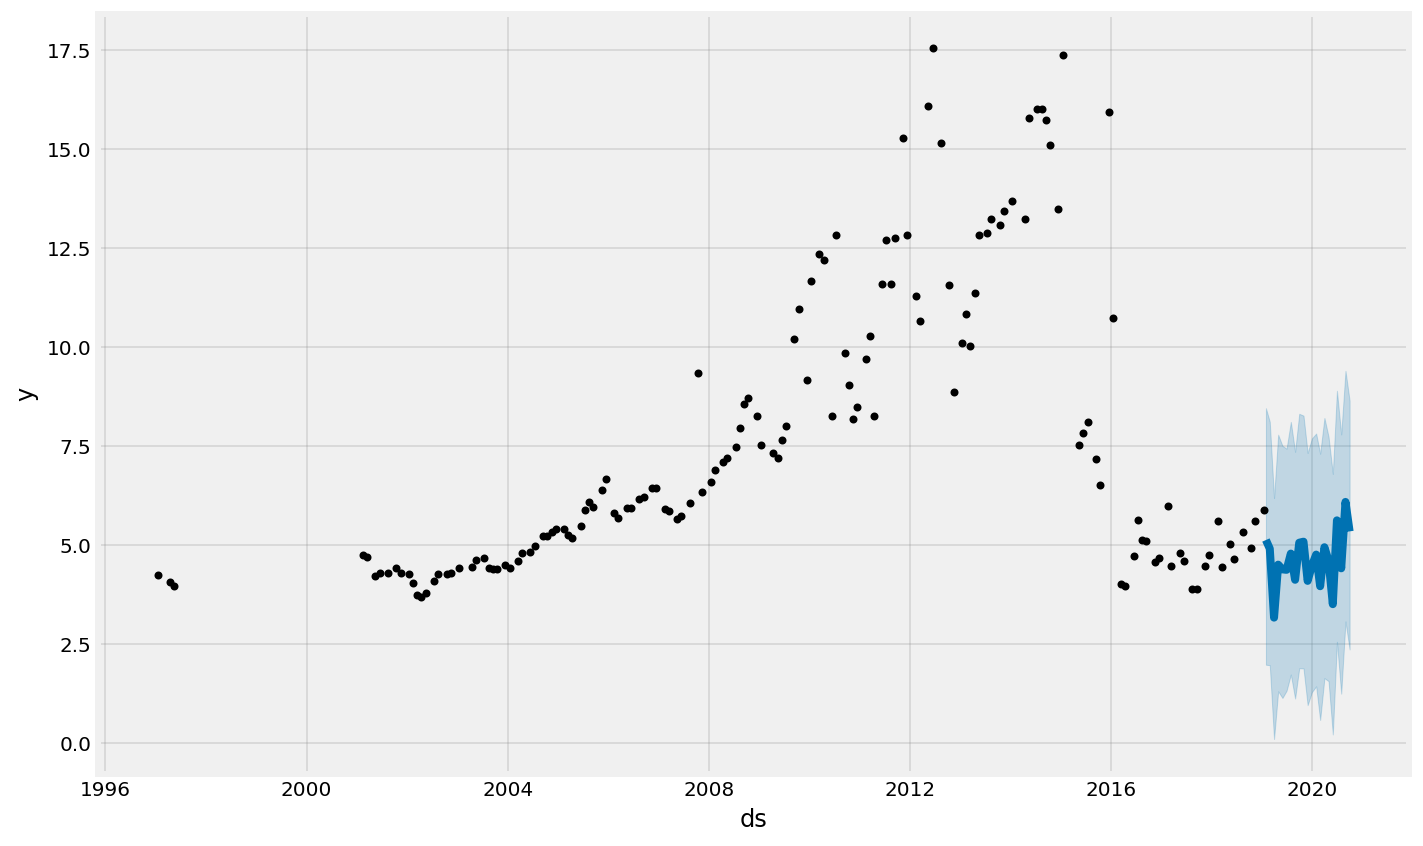

In [902]:
ModelLNGWTI.plot(forecast1, uncertainty= True)
plt.show();

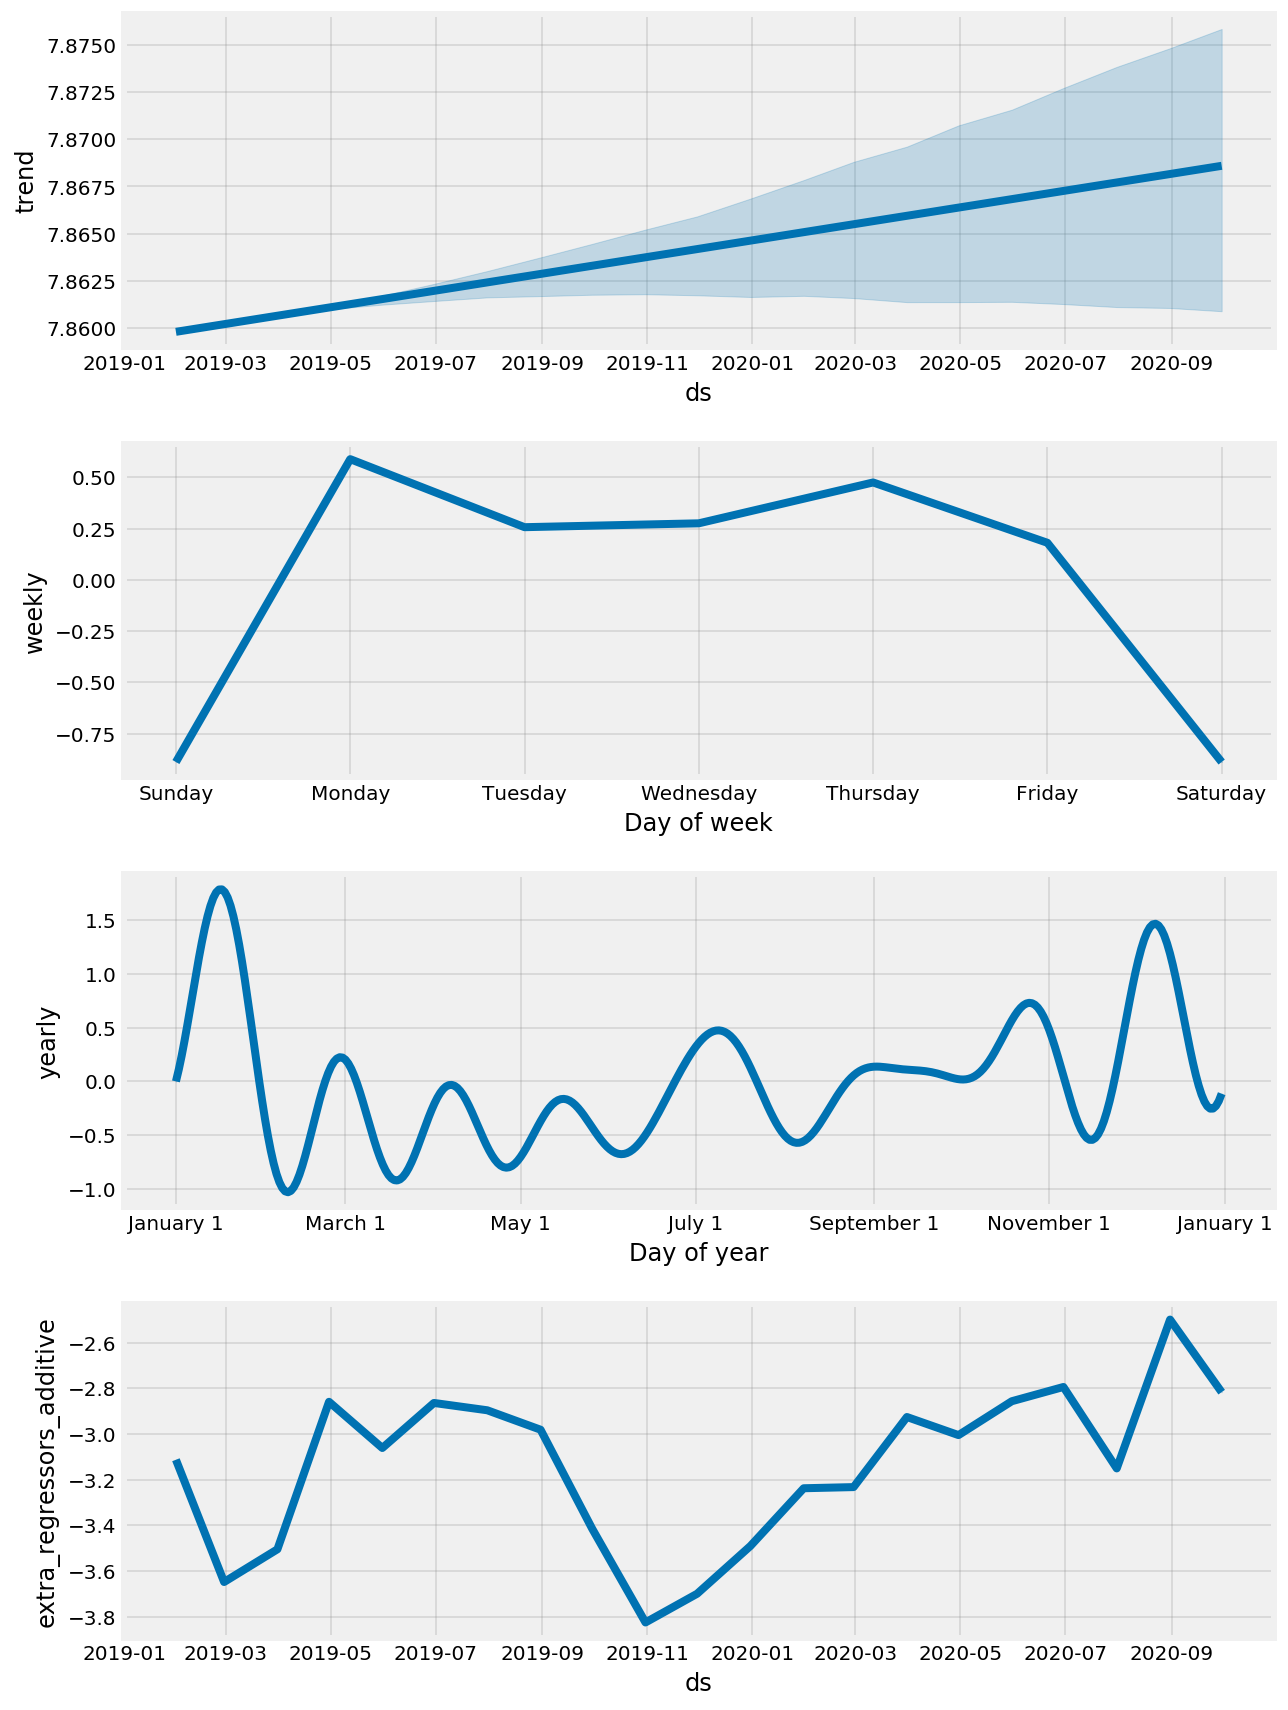

In [903]:
ModelLNGWTI.plot_components(forecast1)
plt.show()

In [905]:
forecast2

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2019-01-31  5.971071    4.121957    9.747653     5.971071     5.971071   
1  2019-02-28  5.895227   12.992072   18.447849     5.895227     5.895227   
2  2019-03-31  5.811257    5.758509   11.482323     5.810769     5.811257   
3  2019-04-30  5.729995  -17.965680  -12.596427     5.727383     5.731690   
4  2019-05-31  5.646025    9.664831   14.963722     5.640024     5.651033   
5  2019-06-30  5.564764   23.782133   29.068731     5.555471     5.573663   
6  2019-07-31  5.480793  -10.881737   -5.746729     5.467244     5.494390   
7  2019-08-31  5.396823    6.493741   12.136470     5.377112     5.416774   
8  2019-09-30  5.315562  -11.876204   -6.697723     5.286746     5.341816   
9  2019-10-31  5.231591   18.524705   24.047994     5.195793     5.263553   
10 2019-11-30  5.150330   13.985992   19.345047     5.107415     5.188305   
11 2019-12-31  5.066359  -20.112683  -14.746003     5.013745     5.112173   
12 2020-01-31  4.982389    1.788225    7.082219     4.919498     5.037514   
13 2020-02-29  4.903836   13.743190   19.452356     4.834989     4.965728   
14 2020-03-31  4.819866    3.806555    9.355313     4.741608     4.889498   
15 2020-04-30  4.738605  -20.564127  -15.116975     4.652355     4.813566   
16 2020-05-31  4.654634    8.908381   14.478307     4.558795     4.743557   
17 2020-06-30  4.573373   21.691849   26.980531     4.468636     4.672059   
18 2020-07-31  4.489403  -10.621331   -5.176090     4.371791     4.596920   
19 2020-08-31  4.405432    5.221298   10.729900     4.276626     4.525304   
20 2020-09-30  4.324171  -13.622904   -8.359520     4.184716     4.452832   
21 2020-10-31  4.240201   18.295529   23.644209     4.090292     4.381956   
22 2020-11-30  4.158939   10.640706   15.884774     3.999284     4.311470   
23 2020-12-31  4.074969  -21.778750  -16.152971     3.905065     4.241272   
24 2021-01-31  3.990999    1.904223    7.763371     3.807544     4.169940   
25 2021-02-28  3.915155   13.057333   18.681071     3.722618     4.103960   
26 2021-03-31  3.831184    3.419059    9.184463     3.626675     4.031702   

    BeijingTemp  BeijingTemp_lower  BeijingTemp_upper  additive_terms  ...  \
0      1.009741           1.009741           1.009741        0.861081  ...   
1     -0.074106          -0.074106          -0.074106        9.834092  ...   
2     -0.630676          -0.630676          -0.630676        2.817049  ...   
3      0.746102           0.746102           0.746102      -20.849012  ...   
4      0.277412           0.277412           0.277412        6.658298  ...   
5     -0.513503          -0.513503          -0.513503       20.884181  ...   
6     -0.279158          -0.279158          -0.279158      -13.790957  ...   
7     -0.689262          -0.689262          -0.689262        3.930410  ...   
8     -0.074106          -0.074106          -0.074106      -14.488192  ...   
9      0.482464           0.482464           0.482464       16.075544  ...   
10     0.570343           0.570343           0.570343       11.696270  ...   
11     0.599637           0.599637           0.599637      -22.405158  ...   
12    -0.103399          -0.103399          -0.103399       -0.417649  ...   
13    -0.161985          -0.161985          -0.161985       11.710528  ...   
14    -0.308451          -0.308451          -0.308451        1.874630  ...   
15    -0.923607          -0.923607          -0.923607      -22.519591  ...   
16    -0.659969          -0.659969          -0.659969        7.141710  ...   
17     0.072360           0.072360           0.072360       19.849912  ...   
18     0.541050           0.541050           0.541050      -12.478467  ...   
19     0.892568           0.892568           0.892568        3.541500  ...   
20    -0.308451          -0.308451          -0.308451      -15.295093  ...   
21    -0.220572          -0.220572          -0.220572       16.680910  ...   
22    -0.689262          -0.689262          -0.689262       

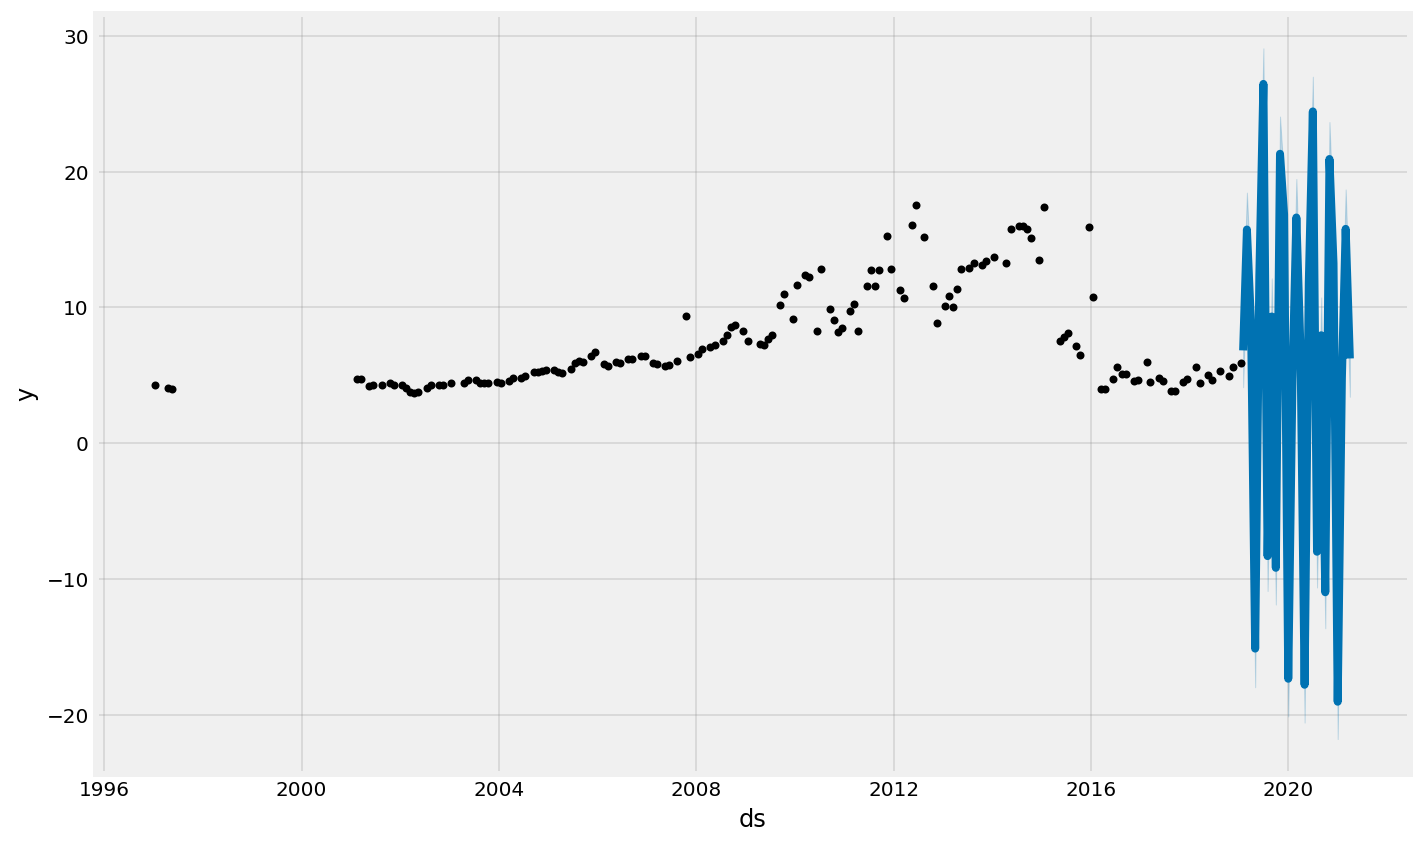

In [907]:
ModelLNGBeijing.plot(forecast2, uncertainty= True)
plt.show();

In [909]:
ModelLNGBeijing.component_modes

{'additive': ['yearly',
  'weekly',
  'BeijingTemp',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

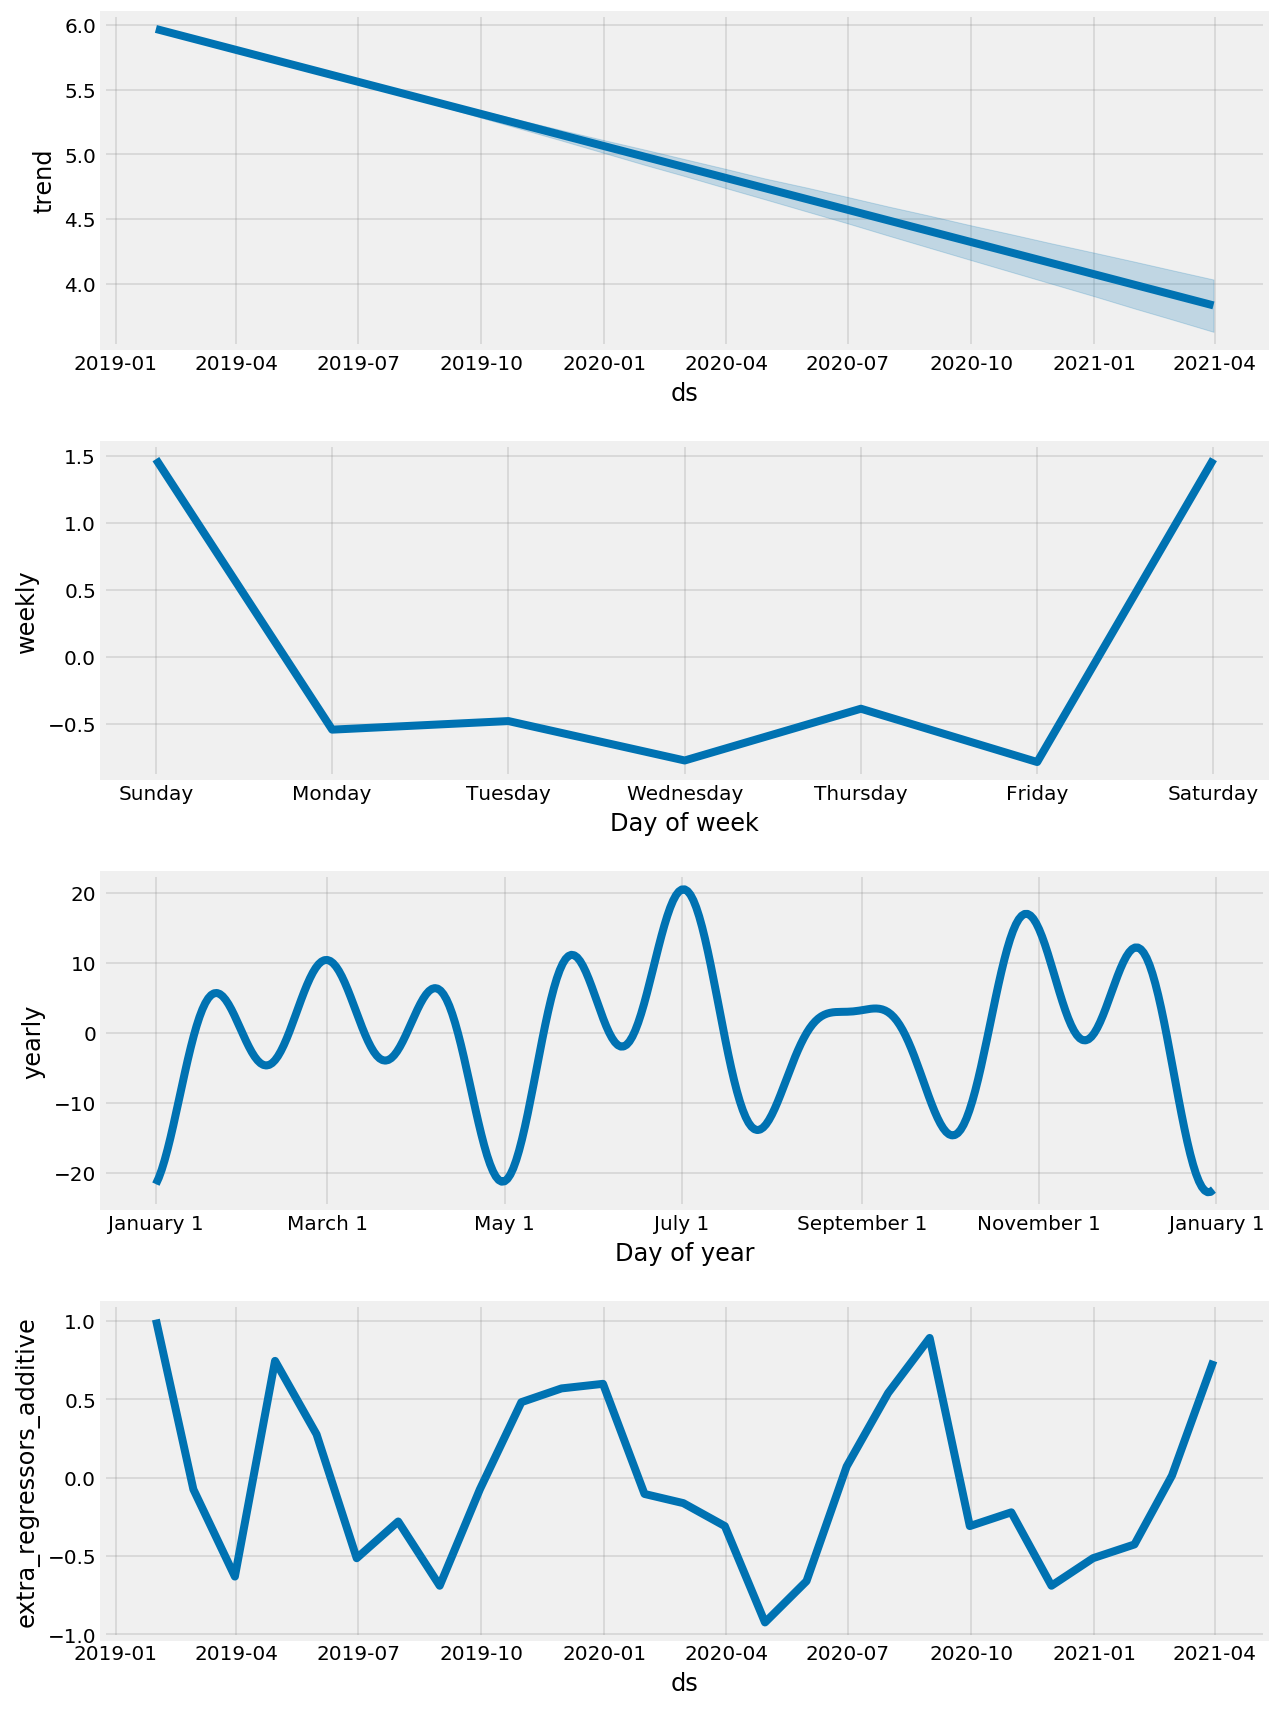

In [908]:
ModelLNGBeijing.plot_components(forecast2)
plt.show()

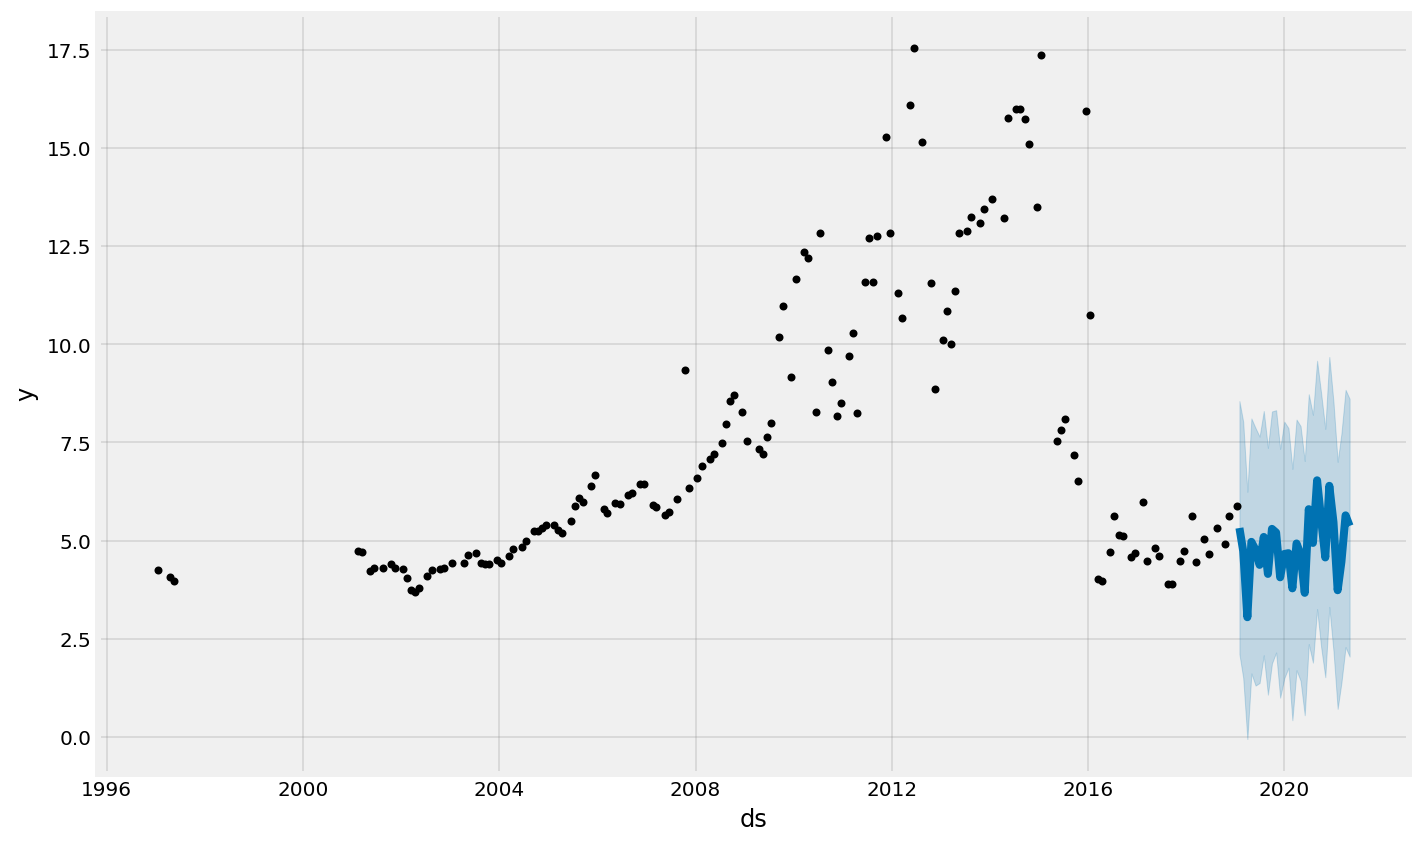

In [901]:
Model.plot(forecast, uncertainty= True)
plt.show();

In [231]:
forecast

<function stldecompose.stl.forecast(stl, fc_func, steps=10, seasonal=False, **fc_func_kwargs)>

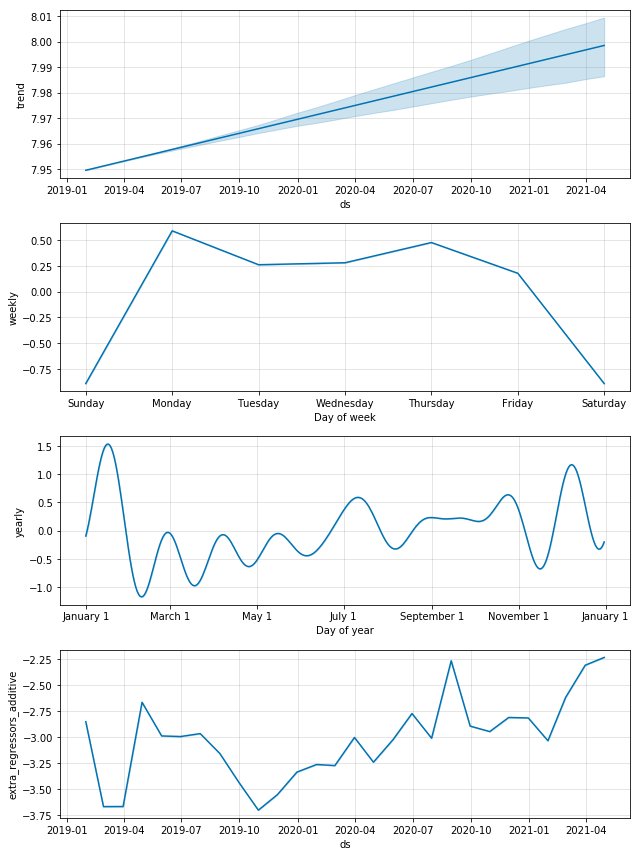

In [155]:
Model.plot_components(forecast)
plt.show()

In [426]:
future_dates

ds
0  2019-01-31
1  2019-02-28
2  2019-03-31
3  2019-04-30
4  2019-05-31
5  2019-06-30
6  2019-07-31
7  2019-08-31
8  2019-09-30
9  2019-10-31
10 2019-11-30
11 2019-12-31
12 2020-01-31
13 2020-02-29
14 2020-03-31
15 2020-04-30
16 2020-05-31
17 2020-06-30
18 2020-07-31
19 2020-08-31
20 2020-09-30
21 2020-10-31
22 2020-11-30
23 2020-12-31
24 2021-01-31
25 2021-02-28
26 2021-03-31
27 2021-04-30

In [431]:
priors=[0.001, 0.02, 0.1, 0.2]

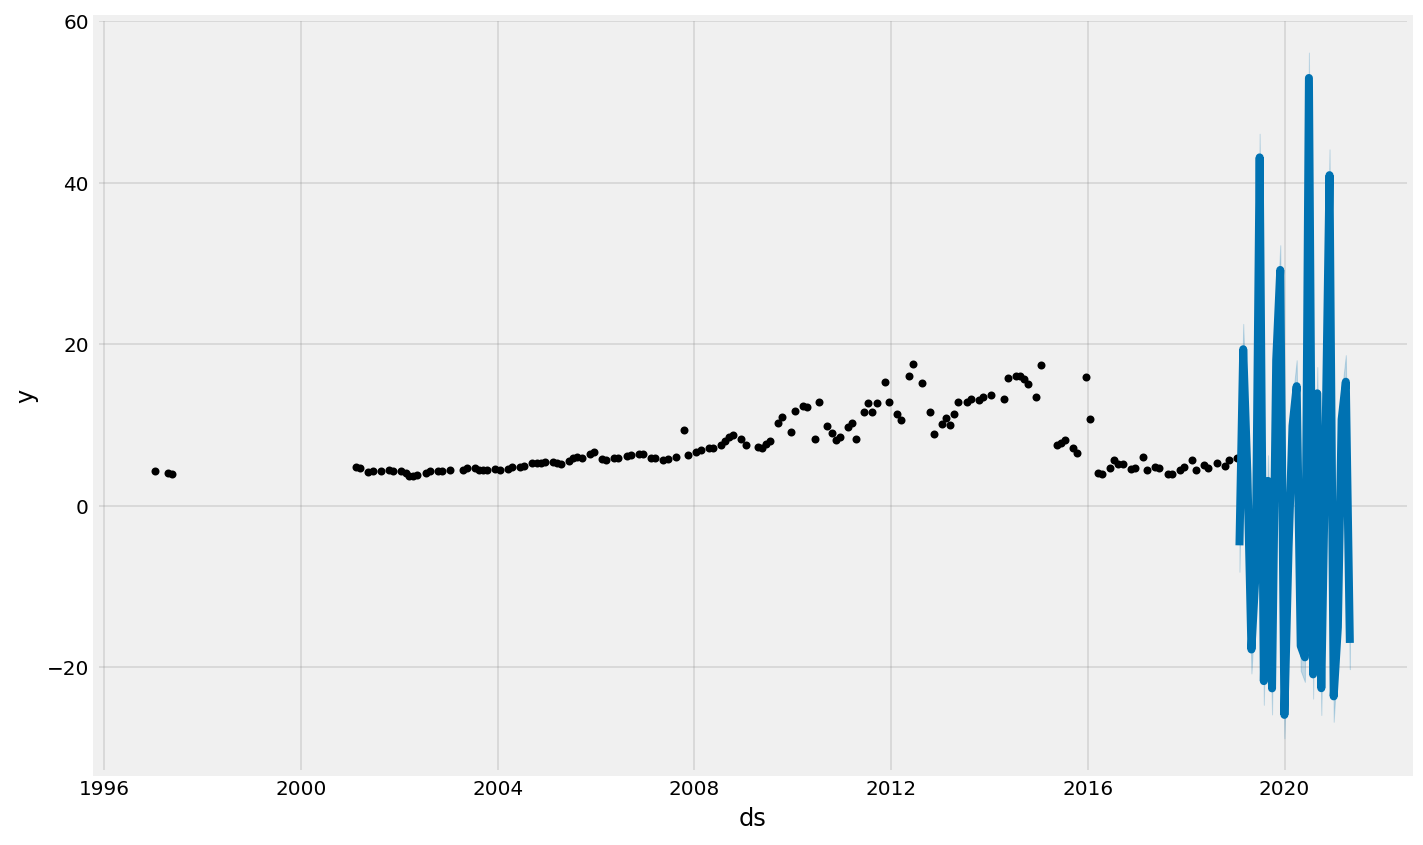

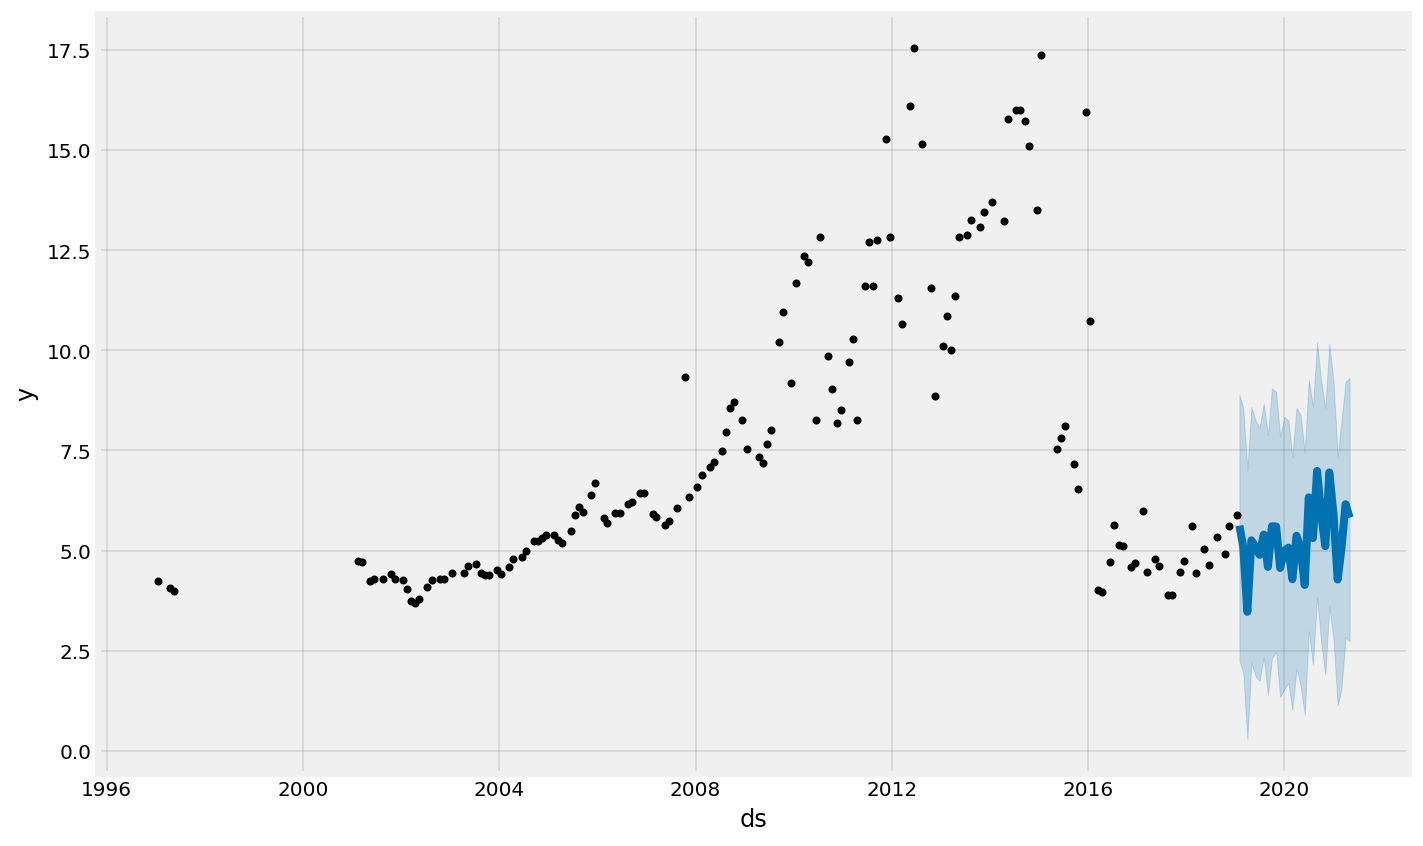

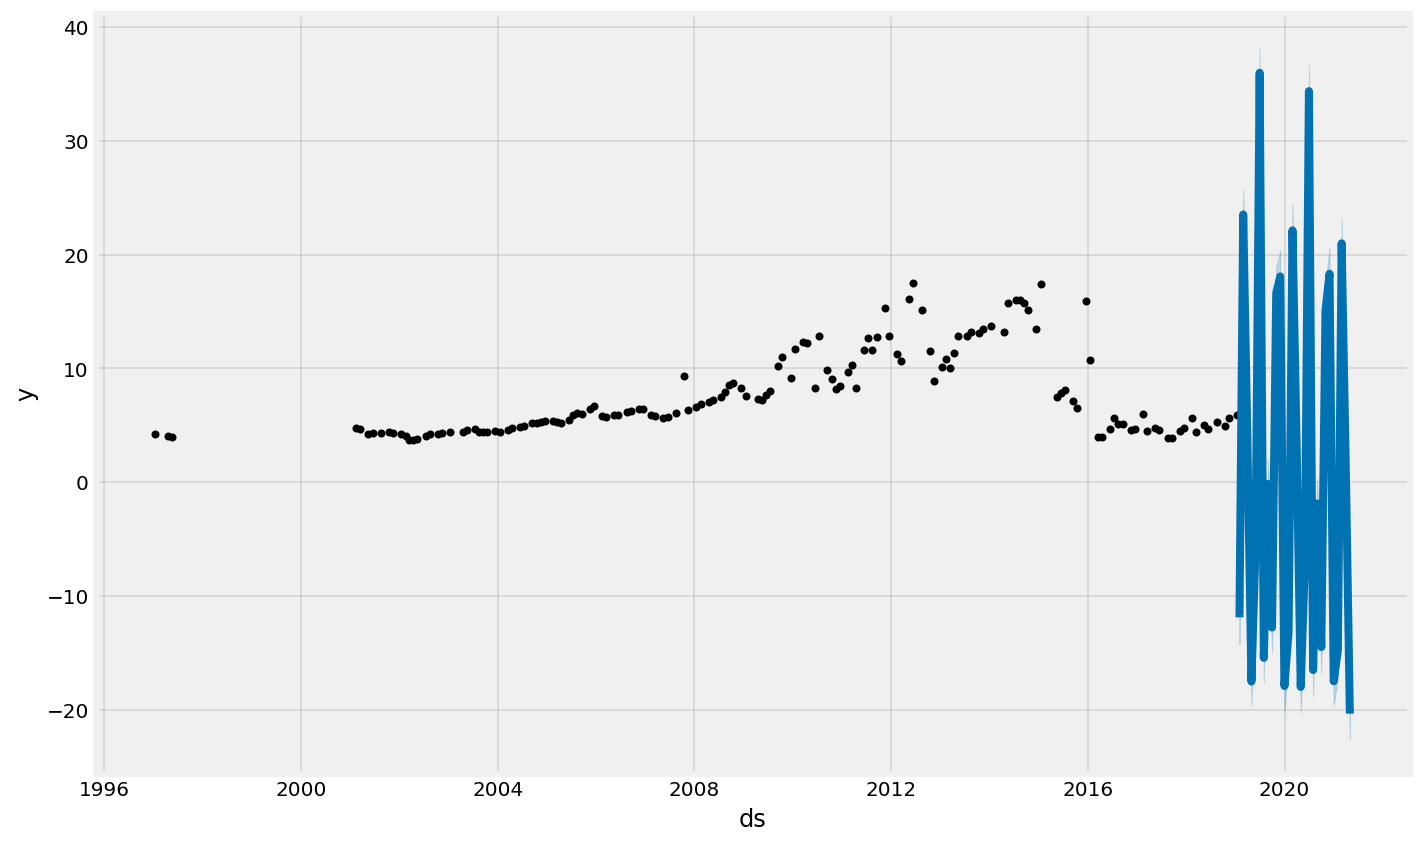

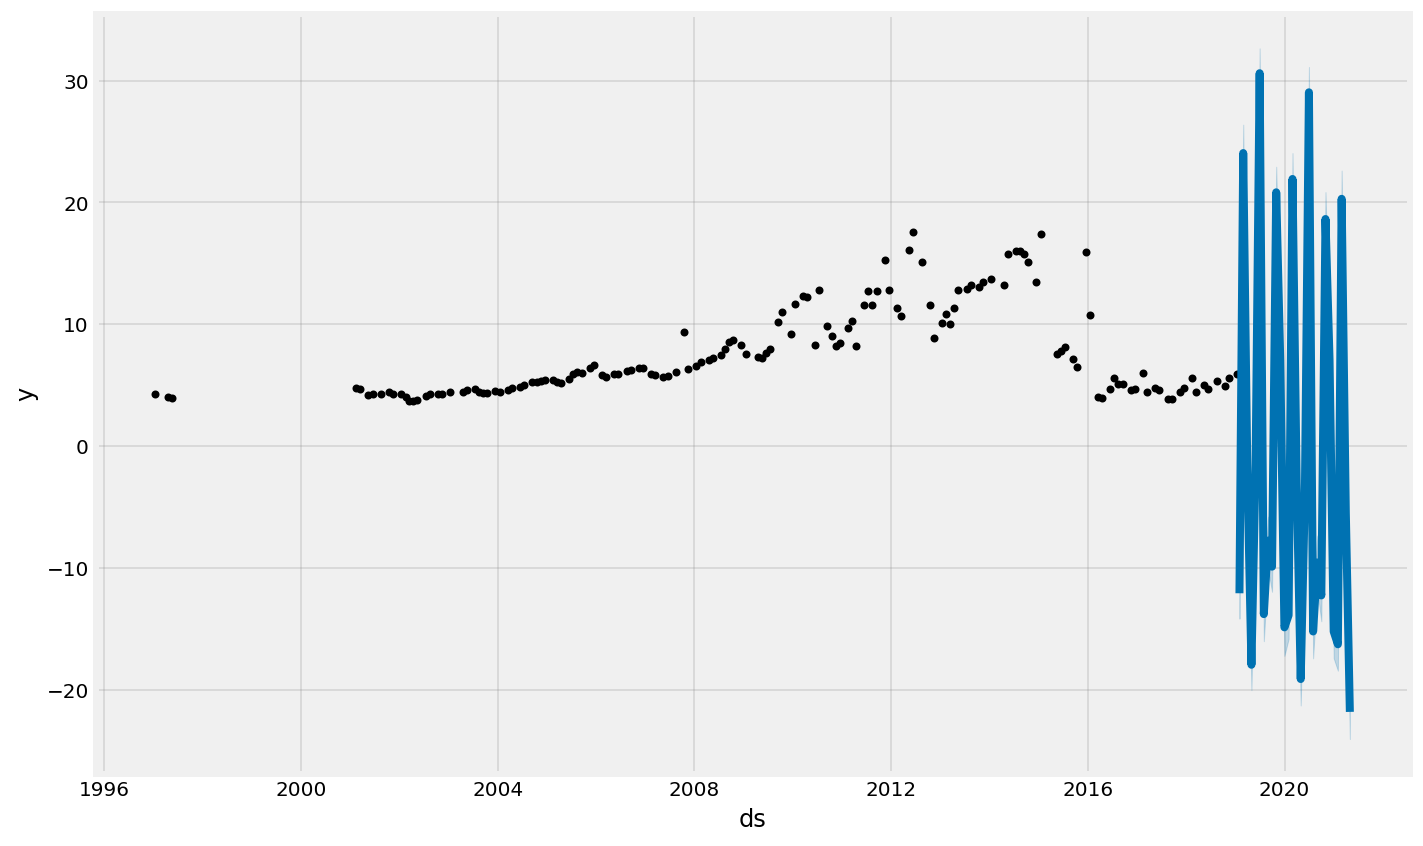

In [432]:
for p in priors:    
    Model= proph(changepoint_prior_scale= p , weekly_seasonality= True, daily_seasonality= False)
    Model.add_regressor('WTI')
    Model.add_regressor('BeijingTemp')
    Model.fit(lngprophet)
    future_dates= Model.make_future_dataframe(periods=28, freq='M', include_history= False )
    future_dates['WTI']= lngprophet['WTI']
    future_dates['WTI'].fillna(lngprophet['WTI'].iloc[-2], inplace=True)
    future_dates['BeijingTemp']= lngprophet['BeijingTemp']
    future_dates['BeijingTemp'].fillna(lngprophet['BeijingTemp'].iloc[-1], inplace=True)
    forecast= Model.predict(future_dates)
    Model.plot(forecast, uncertainty= True)

plt.show();
    

In [726]:
forecast= Model.predict(future_dates)

# RNN- LTSM

## Model Stacked prediction using Yhat from FBProphet

In [727]:
LNG.tail()

index       Date   LNG
218    218 2018-09-15  4.78
219    219 2018-10-15  4.92
220    220 2018-11-15  5.62
221    221 2018-12-15  6.84
222    222 2019-01-15  5.89

In [728]:
df = LNG

In [729]:
df.head()

index       Date   LNG
0      0 1997-01-15  4.25
1      1 1997-02-15  4.29
2      2 1997-03-15  4.22
3      3 1997-04-15  4.06
4      4 1997-05-15  3.98

In [733]:
forecastfuturesdata

index       Date       LNG
0       0 2019-01-31  5.319162
1       1 2019-02-28  4.732352
2       2 2019-03-31  3.044968
3       3 2019-04-30  4.966578
4       4 2019-05-31  4.761178
5       5 2019-06-30  4.379087
6       6 2019-07-31  5.092222
7       7 2019-08-31  4.148665
8       8 2019-09-30  5.297757
9       9 2019-10-31  5.204247
10     10 2019-11-30  4.062007
11     11 2019-12-31  4.657695
12     12 2020-01-31  4.677681
13     13 2020-02-29  3.780455
14     14 2020-03-31  4.925146
15     15 2020-04-30  4.653004
16     16 2020-05-31  3.666185
17     17 2020-06-30  5.799804
18     18 2020-07-31  4.938520
19     19 2020-08-31  6.535632
20     20 2020-09-30  5.543381
21     21 2020-10-31  4.569161
22     22 2020-11-30  6.394967
23     23 2020-12-31  5.466053
24     24 2021-01-31  3.732710
25     25 2021-02-28  4.457073
26     26 2021-03-31  5.642017
27     27 2021-04-30  5.372448

In [738]:
forecastfuturesdata.drop(columns= ['index'], axis=1, inplace= True)

In [717]:
forecastfuturesdata.reset_index(inplace=True)

In [740]:
forecastfuturesdata.columns

Index(['Date', 'LNG'], dtype='object')

In [741]:
df.tail()

index       Date   LNG
218    218 2018-09-15  4.78
219    219 2018-10-15  4.92
220    220 2018-11-15  5.62
221    221 2018-12-15  6.84
222    222 2019-01-15  5.89

df.reset_index(inplace= True)

df.columns = ['Date', 'LNG']

In [742]:
df.drop(columns= ['index'], axis=1, inplace= True)

In [743]:
df.head()

Date   LNG
0 1997-01-15  4.25
1 1997-02-15  4.29
2 1997-03-15  4.22
3 1997-04-15  4.06
4 1997-05-15  3.98

In [744]:
nextdf= pd.concat([df, forecastfuturesdata], axis=0, sort= True)

In [745]:
nextdf.tail()

Date      LNG
23 2020-12-31  5.46605
24 2021-01-31  3.73271
25 2021-02-28  4.45707
26 2021-03-31  5.64202
27 2021-04-30  5.37245

In [746]:
nextdf.tail()

Date      LNG
23 2020-12-31  5.46605
24 2021-01-31  3.73271
25 2021-02-28  4.45707
26 2021-03-31  5.64202
27 2021-04-30  5.37245

In [748]:
nextdf.reset_index(inplace= True)

In [749]:
#For stacked model 

data = nextdf.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(nextdf)),columns=['Date', 'LNG'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['LNG'][i] = data['LNG'][i]

In [750]:
new_data

Date      LNG
0    1997-01-15 00:00:00     4.25
1    1997-02-15 00:00:00     4.29
2    1997-03-15 00:00:00     4.22
3    1997-04-15 00:00:00     4.06
4    1997-05-15 00:00:00     3.98
5    1997-06-15 00:00:00     4.22
6    2001-01-15 00:00:00     4.69
7    2001-02-15 00:00:00     4.74
8    2001-03-15 00:00:00     4.71
9    2001-04-15 00:00:00     4.26
10   2001-05-15 00:00:00     4.23
11   2001-06-15 00:00:00     4.29
12   2001-07-15 00:00:00     4.28
13   2001-08-15 00:00:00      4.3
14   2001-09-15 00:00:00      4.4
15   2001-10-15 00:00:00     4.41
16   2001-11-15 00:00:00      4.3
17   2001-12-15 00:00:00      4.3
18   2002-01-15 00:00:00     4.27
19   2002-02-15 00:00:00     4.04
20   2002-03-15 00:00:00     3.74
21   2002-04-15 00:00:00     3.68
22   2002-05-15 00:00:00     3.79
23   2002-06-15 00:00:00     3.85
24   2002-07-15 00:00:00     4.09
25   2002-08-15 00:00:00     4.26
26   2002-09-15 00:00:00      4.3
27   2002-10-15 00:00:00     4.28
28   2002-11-15 00:00:00      4.3
29   2002-12-15 00:00:00     4.34
..                   ...      ...
221  2018-12-15 00:00:00     6.84
222  2019-01-15 00:00:00     5.89
223  2019-01-31 00:00:00  5.31916
224  2019-02-28 00:00:00  4.73235
225  2019-03-31 00:00:00  3.04497
226  2019-04-30 00:00:00  4.96658
227  2019-05-31 00:00:00  4.76118
228  2019-06-30 00:00:00  4.37909
229  2019-07-31 00:00:00  5.09222
230  2019-08-31 00:00:00  4.14866
231  2019-09-30 00:00:00  5.29776
232  2019-10-31 00:00:00  5.20425
233  2019-11-30 00:00:00  4.06201
234  2019-12-31 00:00:00  4.65769
235  2020-01-31 00:00:00  4.67768
236  2020-02-29 00:00:00  3.78046
237  2020-03-31 00:00:00  4.92515
238  2020-04-30 00:00:00    4.653
239  2020-05-31 00:00:00  3.66619
240  2020-06-30 00:00:00   5.7998
241  2020-07-31 00:00:00  4.93852
242  2020-08-31 00:00:00  6.53563
243  2020-09-30 00:00:00  5.54338
244  2020-10-31 00:00:00  4.56916
245  2020-11-30 00:00:00  6.39497
246  2020-12-31 00:00:00  5.46605
247  2021-01-31 00:00:00  3.73271
248  2021-02-28 00:00:00  4.45707
249  2021-03-31 00:00:00  5.64202
250  2021-04-30 00:00:00  5.37245

[251 rows x 2 columns]

In [751]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [752]:
#creating train and test sets (80% train, 20% valid)
dataset = new_data.values
split= int(.8*len(nextdf))
train = dataset[0:split,:]
valid = dataset[split:,:]

In [753]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [754]:
# Create a data structure with 60 timesteps and 1 output
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshaping (batch_size, timesteps, input_dim)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [756]:
#predicting values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1)) #1 output (prediction of next day)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

model.save('RNN-LNGstackeedFB.h5')

In [757]:
model= load_model('RNN-LNGstackeedFB.h5')

In [758]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [759]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

1.826033579078465

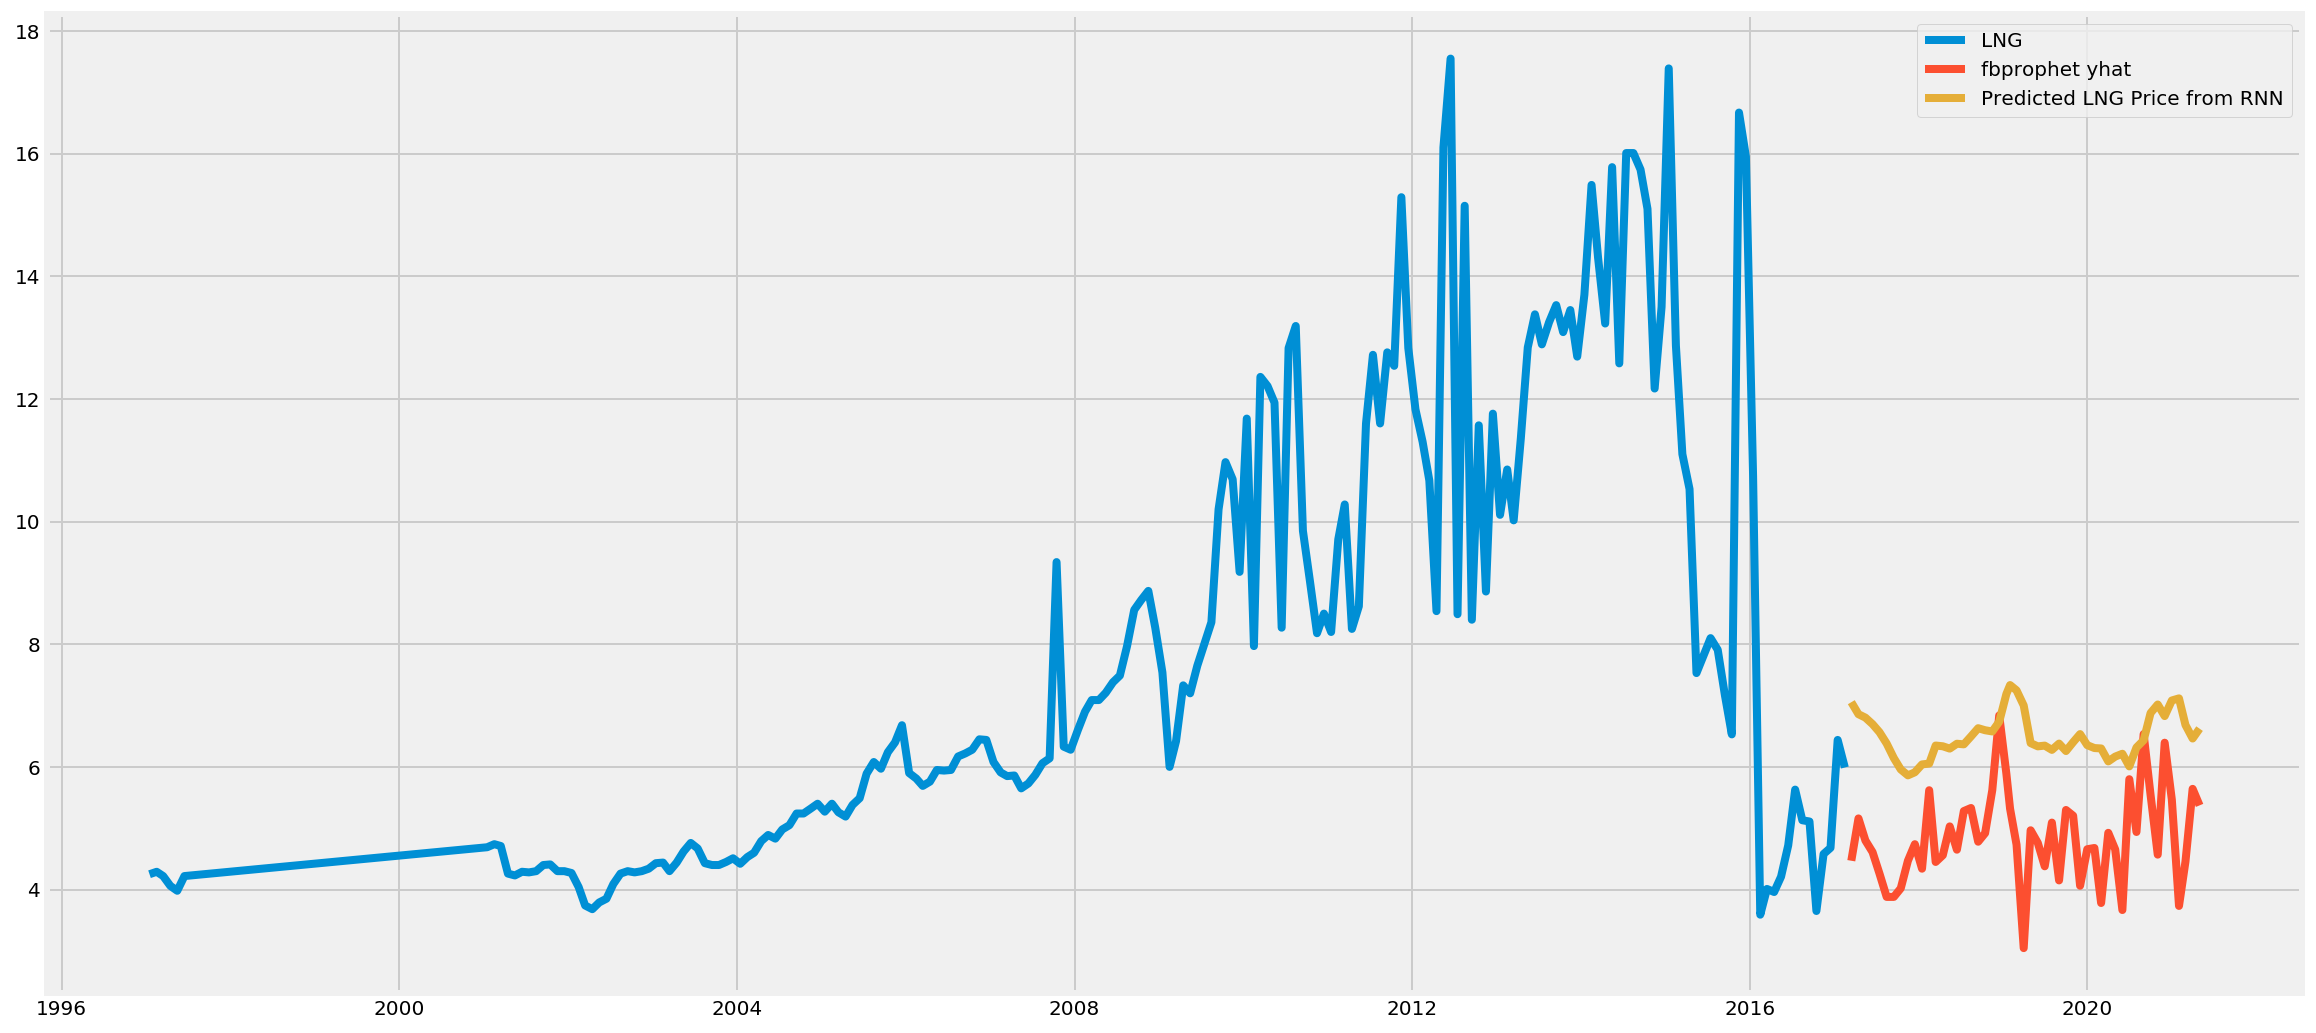

In [760]:
#for plotting
train = new_data[:split]
valid = new_data[split:]
valid['Predictions'] = closing_price
plt.figure(figsize=(18,9))
plt.plot(train['LNG'])
plt.plot(valid['LNG'], label = 'fbprophet yhat')
plt.plot(valid['Predictions'], label = 'Predicted LNG Price from RNN')
plt.legend()
plt.show();

In [625]:
nextdf= pd.concat([df, forecastfuturesdata], axis=0, sort= True)

In [626]:
nextdf.head()

Date   LNG
0 1997-01-15  4.25
1 1997-02-15  4.29
2 1997-03-15  4.22
3 1997-04-15  4.06
4 1997-05-15  3.98

In [627]:
nextdf.set_index('Date', inplace= True)

In [628]:
nextdf.reset_index(inplace= True)

In [629]:
nextdf.head()

Date   LNG
0 1997-01-15  4.25
1 1997-02-15  4.29
2 1997-03-15  4.22
3 1997-04-15  4.06
4 1997-05-15  3.98

### Stacked Model data 

In [795]:
#For stacked model 

data = nextdf.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(nextdf)),columns=['Date', 'LNG'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['LNG'][i] = data['LNG'][i]

data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'LNG'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['LNG'][i] = data['LNG'][i]

In [813]:
new_data.set_index(['Date'], inplace= True)

In [814]:
new_data.tail()

LNG
Date               
2020-12-31  5.46605
2021-01-31  3.73271
2021-02-28  4.45707
2021-03-31  5.64202
2021-04-30  5.37245

In [815]:
split= int(.9*len(nextdf))

In [816]:
split

225

In [817]:
#creating train and test sets (90% train, 10% valid)
dataset = new_data.values
train = dataset[0:split,:]
valid = dataset[split:,:]

In [585]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [818]:
train

array([[4.25],
       [4.29],
       [4.22],
       [4.06],
       [3.98],
       [4.22],
       [4.69],
       [4.74],
       [4.71],
       [4.26],
       [4.23],
       [4.29],
       [4.28],
       [4.3],
       [4.4],
       [4.41],
       [4.3],
       [4.3],
       [4.27],
       [4.04],
       [3.74],
       [3.68],
       [3.79],
       [3.85],
       [4.09],
       [4.26],
       [4.3],
       [4.28],
       [4.3],
       [4.34],
       [4.43],
       [4.44],
       [4.3],
       [4.44],
       [4.62],
       [4.76],
       [4.67],
       [4.43],
       [4.4],
       [4.4],
       [4.45],
       [4.51],
       [4.42],
       [4.53],
       [4.6],
       [4.79],
       [4.89],
       [4.83],
       [4.98],
       [5.05],
       [5.24],
       [5.24],
       [5.32],
       [5.4],
       [5.27],
       [5.4],
       [5.26],
       [5.19],
       [5.38],
       [5.49],
       [5.89],
       [6.08],
       [5.97],
       [6.24],
       [6.4],
       [6.68],
       [5.9],
       [5

In [819]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [820]:
# Create a data structure with 60 timesteps and 1 output
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshaping (batch_size, timesteps, input_dim)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [821]:
x_train.shape

(165, 60, 1)

In [822]:
y_train.shape

(165,)

In [823]:
#predicting values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1)) #1 output (prediction of next day)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

model.save('RNN-LNGstackeedFB.h5')

In [824]:
X_test.shape

(26, 60)

In [825]:
from keras.models import load_model

In [826]:
model = load_model('RNN-LNGstackeedFB.h5')

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [827]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

1.8822375140518937

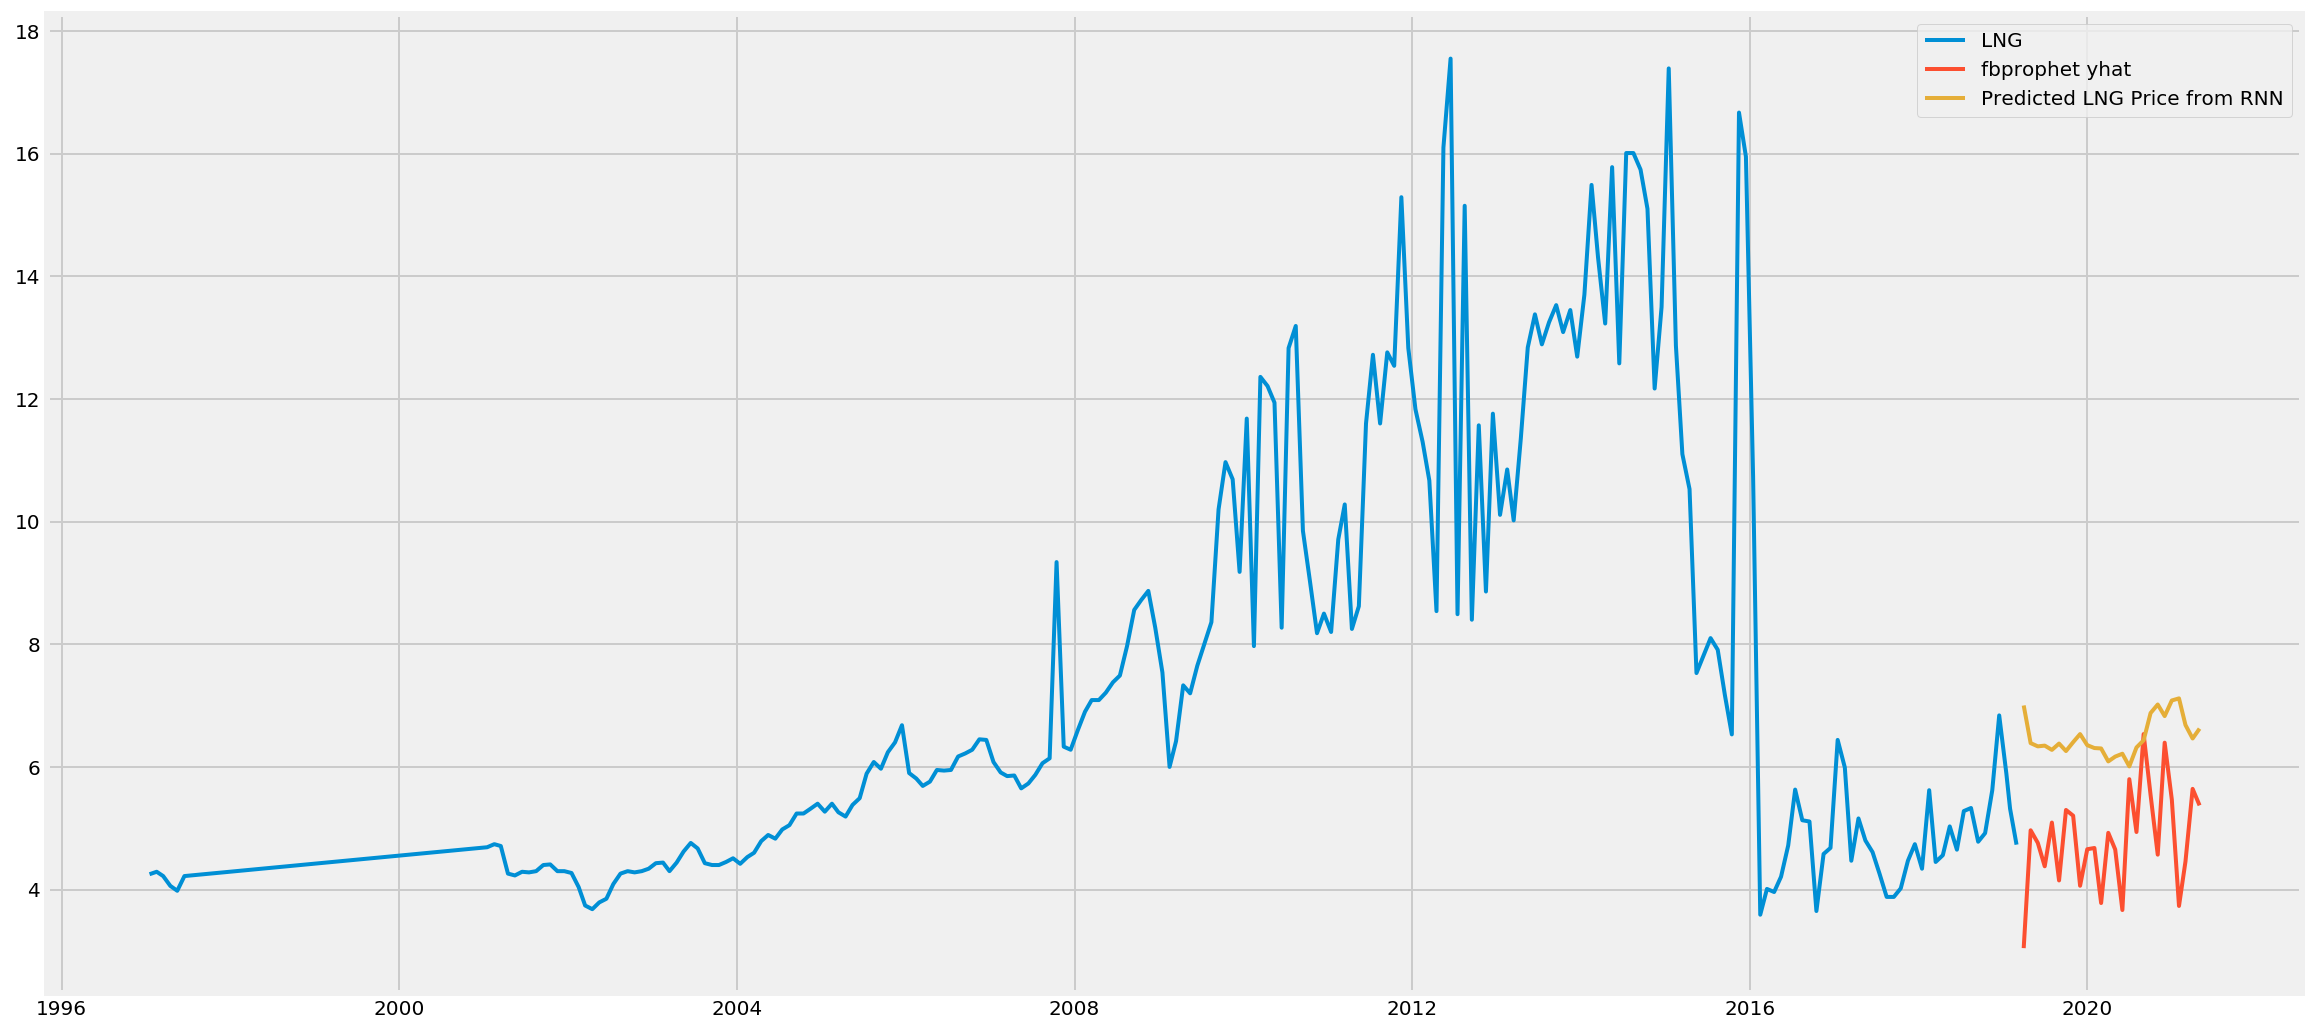

In [828]:
#for plotting
train = new_data[:split]
valid = new_data[split:]
valid['Predictions'] = closing_price
plt.figure(figsize=(18,9))
plt.plot(train['LNG'], linewidth= 2)
plt.plot(valid['LNG'],linewidth= 2, label = 'fbprophet yhat')
plt.plot(valid['Predictions'],linewidth= 2, label = 'Predicted LNG Price from RNN')
plt.legend()
plt.show();

In [829]:
valid.tail(30)

LNG  Predictions
Date                            
2019-03-31  3.04497     7.001784
2019-04-30  4.96658     6.387873
2019-05-31  4.76118     6.335085
2019-06-30  4.37909     6.347126
2019-07-31  5.09222     6.277426
2019-08-31  4.14866     6.380347
2019-09-30  5.29776     6.258731
2019-10-31  5.20425     6.403329
2019-11-30  4.06201     6.535367
2019-12-31  4.65769     6.354433
2020-01-31  4.67768     6.307502
2020-02-29  3.78046     6.300919
2020-03-31  4.92515     6.089643
2020-04-30    4.653     6.168071
2020-05-31  3.66619     6.214665
2020-06-30   5.7998     6.008339
2020-07-31  4.93852     6.316566
2020-08-31  6.53563     6.434484
2020-09-30  5.54338     6.878217
2020-10-31  4.56916     7.017842
2020-11-30  6.39497     6.828782
2020-12-31  5.46605     7.083251
2021-01-31  3.73271     7.117489
2021-02-28  4.45707     6.683505
2021-03-31  5.64202     6.463147
2021-04-30  5.37245     6.623962

# 'Model with split percentage moved to 90% and and time frame window changes to 12--- 12 months in a year'



In [836]:
nextdf.drop(['index'], axis=1, inplace= True)

KeyError: "['index'] not found in axis"

In [837]:
nextdf

Date      LNG
0   1997-01-15     4.25
1   1997-02-15     4.29
2   1997-03-15     4.22
3   1997-04-15     4.06
4   1997-05-15     3.98
5   1997-06-15     4.22
6   2001-01-15     4.69
7   2001-02-15     4.74
8   2001-03-15     4.71
9   2001-04-15     4.26
10  2001-05-15     4.23
11  2001-06-15     4.29
12  2001-07-15     4.28
13  2001-08-15      4.3
14  2001-09-15      4.4
15  2001-10-15     4.41
16  2001-11-15      4.3
17  2001-12-15      4.3
18  2002-01-15     4.27
19  2002-02-15     4.04
20  2002-03-15     3.74
21  2002-04-15     3.68
22  2002-05-15     3.79
23  2002-06-15     3.85
24  2002-07-15     4.09
25  2002-08-15     4.26
26  2002-09-15      4.3
27  2002-10-15     4.28
28  2002-11-15      4.3
29  2002-12-15     4.34
..         ...      ...
221 2018-12-15     6.84
222 2019-01-15     5.89
223 2019-01-31  5.31916
224 2019-02-28  4.73235
225 2019-03-31  3.04497
226 2019-04-30  4.96658
227 2019-05-31  4.76118
228 2019-06-30  4.37909
229 2019-07-31  5.09222
230 2019-08-31  4.14866
231 2019-09-30  5.29776
232 2019-10-31  5.20425
233 2019-11-30  4.06201
234 2019-12-31  4.65769
235 2020-01-31  4.67768
236 2020-02-29  3.78046
237 2020-03-31  4.92515
238 2020-04-30    4.653
239 2020-05-31  3.66619
240 2020-06-30   5.7998
241 2020-07-31  4.93852
242 2020-08-31  6.53563
243 2020-09-30  5.54338
244 2020-10-31  4.56916
245 2020-11-30  6.39497
246 2020-12-31  5.46605
247 2021-01-31  3.73271
248 2021-02-28  4.45707
249 2021-03-31  5.64202
250 2021-04-30  5.37245

[251 rows x 2 columns]

In [838]:
#For stacked model 

data = nextdf.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(nextdf)),columns=['Date', 'LNG'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['LNG'][i] = data['LNG'][i]

In [839]:
new_data.head()

Date   LNG
0  1997-01-15 00:00:00  4.25
1  1997-02-15 00:00:00  4.29
2  1997-03-15 00:00:00  4.22
3  1997-04-15 00:00:00  4.06
4  1997-05-15 00:00:00  3.98

In [834]:
new_data.set_index('Date', inplace= True)

In [840]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [841]:
#creating train and test sets (80% train, 20% valid)
dataset = new_data.values
split= int(.9*len(nextdf))
train = dataset[0:split,:]
valid = dataset[split:,:]

In [842]:
dataset

array([[4.25],
       [4.29],
       [4.22],
       [4.06],
       [3.98],
       [4.22],
       [4.69],
       [4.74],
       [4.71],
       [4.26],
       [4.23],
       [4.29],
       [4.28],
       [4.3],
       [4.4],
       [4.41],
       [4.3],
       [4.3],
       [4.27],
       [4.04],
       [3.74],
       [3.68],
       [3.79],
       [3.85],
       [4.09],
       [4.26],
       [4.3],
       [4.28],
       [4.3],
       [4.34],
       [4.43],
       [4.44],
       [4.3],
       [4.44],
       [4.62],
       [4.76],
       [4.67],
       [4.43],
       [4.4],
       [4.4],
       [4.45],
       [4.51],
       [4.42],
       [4.53],
       [4.6],
       [4.79],
       [4.89],
       [4.83],
       [4.98],
       [5.05],
       [5.24],
       [5.24],
       [5.32],
       [5.4],
       [5.27],
       [5.4],
       [5.26],
       [5.19],
       [5.38],
       [5.49],
       [5.89],
       [6.08],
       [5.97],
       [6.24],
       [6.4],
       [6.68],
       [5.9],
       [5

In [843]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset.reshape(-1,1))

In [844]:
scaled_data

array([[0.08307683],
       [0.08583449],
       [0.08100858],
       [0.06997792],
       [0.0644626 ],
       [0.08100858],
       [0.11341113],
       [0.11685821],
       [0.11478996],
       [0.08376624],
       [0.081698  ],
       [0.08583449],
       [0.08514507],
       [0.08652391],
       [0.09341807],
       [0.09410748],
       [0.08652391],
       [0.08652391],
       [0.08445566],
       [0.06859909],
       [0.04791662],
       [0.04378012],
       [0.05136369],
       [0.05550019],
       [0.07204617],
       [0.08376624],
       [0.08652391],
       [0.08514507],
       [0.08652391],
       [0.08928157],
       [0.09548631],
       [0.09617573],
       [0.08652391],
       [0.09617573],
       [0.10858522],
       [0.11823704],
       [0.1120323 ],
       [0.09548631],
       [0.09341807],
       [0.09341807],
       [0.09686515],
       [0.10100164],
       [0.0947969 ],
       [0.10238047],
       [0.10720638],
       [0.12030529],
       [0.12719945],
       [0.123

In [845]:
# Create a data structure with 12 timesteps and 1 output
x_train, y_train = [], []
for i in range(12,len(train)):
    x_train.append(scaled_data[i-12:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshaping (batch_size, timesteps, input_dim)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [846]:
x_train.shape

(213, 12, 1)

In [847]:
y_train.shape

(213,)

In [848]:
#predicting values, using past 12 from the train data
inputs = new_data[len(new_data) - len(valid) - 12:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(12,inputs.shape[0]):
    X_test.append(inputs[i-12:i,0])
X_test = np.array(X_test)

In [849]:
inputs

array([[0.10444872],
       [0.13685127],
       [0.11065346],
       [0.15408667],
       [0.15753375],
       [0.11961587],
       [0.12926769],
       [0.17752681],
       [0.26163555],
       [0.19614104],
       [0.15678658],
       [0.11633094],
       [0.        ],
       [0.13247889],
       [0.11831823],
       [0.09197628],
       [0.14114098],
       [0.07609061],
       [0.15531084],
       [0.14886412],
       [0.07011631],
       [0.11118394],
       [0.11256187],
       [0.05070568],
       [0.12962245],
       [0.11086059],
       [0.04282771],
       [0.18992281],
       [0.13054449],
       [0.24065196],
       [0.17224459],
       [0.10508027],
       [0.23095425],
       [0.16691343],
       [0.04741403],
       [0.09735276],
       [0.17904471],
       [0.16046018]])

In [850]:
modeladj= load_model('RNN-stackedNinesplitwithwindow.h5')

In [851]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = modeladj.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [852]:
closing_price

array([[5.4795284],
       [4.808774 ],
       [4.93316  ],
       [5.0429177],
       [4.974227 ],
       [5.111136 ],
       [4.9334283],
       [5.121367 ],
       [5.2364335],
       [4.9405847],
       [4.899435 ],
       [4.915305 ],
       [4.671943 ],
       [4.8486547],
       [4.9035635],
       [4.631917 ],
       [5.058752 ],
       [5.1337466],
       [5.6225133],
       [5.6490226],
       [5.335689 ],
       [5.683997 ],
       [5.6860456],
       [5.1451817],
       [4.9980664],
       [5.3012824]], dtype=float32)

In [853]:
valid.set_index('Date',inplace=True)

AttributeError: 'numpy.ndarray' object has no attribute 'set_index'

In [854]:
valid

array([[3.044967962118265],
       [4.966578458642752],
       [4.761177635197113],
       [4.379086862409656],
       [5.092222470140405],
       [4.148664671551371],
       [5.297756710215216],
       [5.204246849350124],
       [4.062007275803795],
       [4.657694575350337],
       [4.67768143798142],
       [3.780455464037077],
       [4.925145710295188],
       [4.653004349630609],
       [3.666185312939395],
       [5.799804360106566],
       [4.9385199164007805],
       [6.535632401228243],
       [5.543381268540545],
       [4.569160654819385],
       [6.394966695687167],
       [5.466052664647149],
       [3.7327099548772527],
       [4.4570729170601435],
       [5.642017284080998],
       [5.372447971743762]], dtype=object)

In [855]:
closing_price

array([[5.4795284],
       [4.808774 ],
       [4.93316  ],
       [5.0429177],
       [4.974227 ],
       [5.111136 ],
       [4.9334283],
       [5.121367 ],
       [5.2364335],
       [4.9405847],
       [4.899435 ],
       [4.915305 ],
       [4.671943 ],
       [4.8486547],
       [4.9035635],
       [4.631917 ],
       [5.058752 ],
       [5.1337466],
       [5.6225133],
       [5.6490226],
       [5.335689 ],
       [5.683997 ],
       [5.6860456],
       [5.1451817],
       [4.9980664],
       [5.3012824]], dtype=float32)

In [856]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.9266639113954999

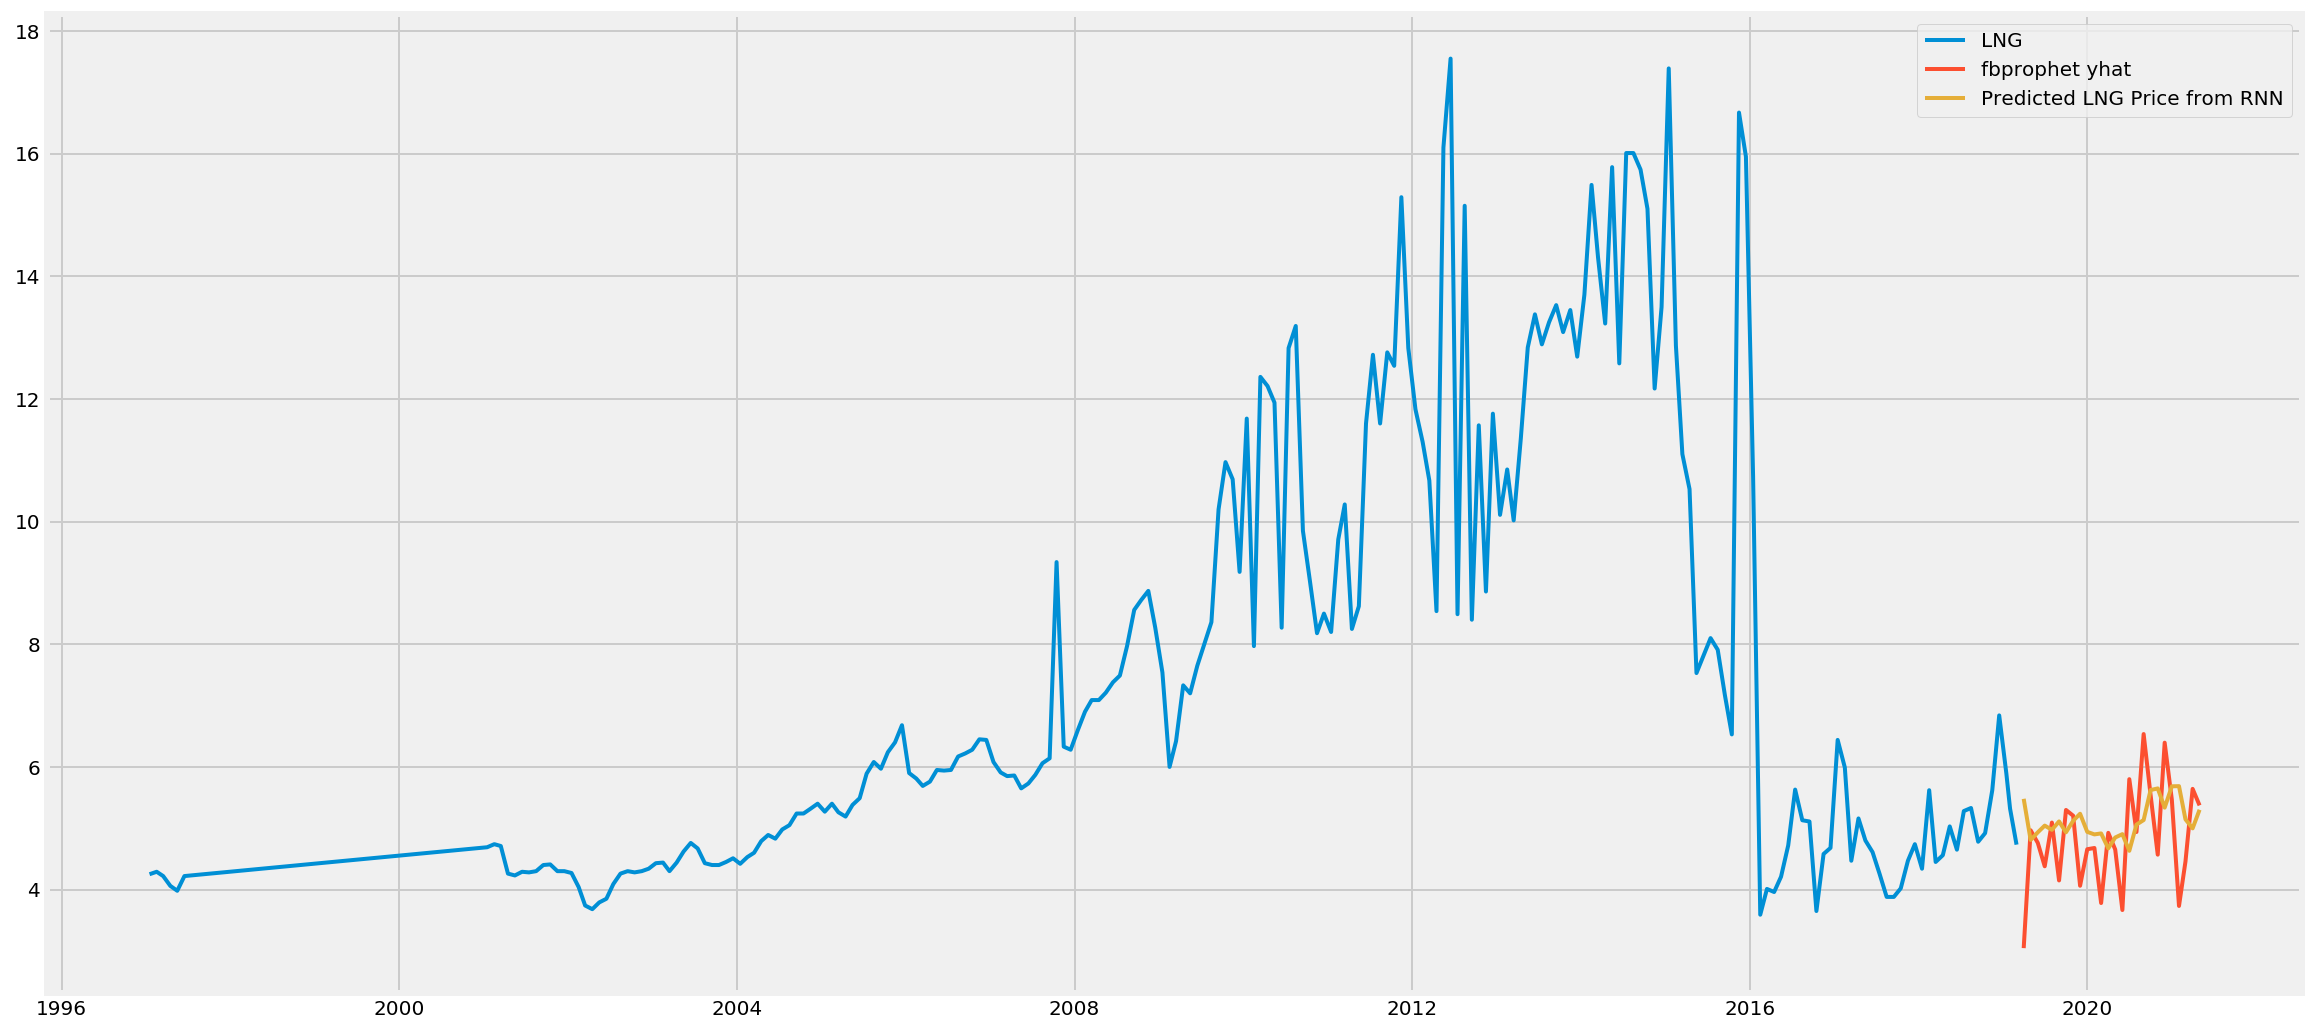

In [857]:
#for plotting
train = new_data[:split]
valid = new_data[split:]
valid['Predictions'] = closing_price
plt.figure(figsize=(18,9))
plt.plot(train['LNG'], linewidth= 2)
plt.plot(valid['LNG'], label = 'fbprophet yhat',linewidth= 2)
plt.plot(valid['Predictions'], linewidth= 2, label = 'Predicted LNG Price from RNN')
plt.legend()
plt.show();

In [858]:
valid.tail(30)

LNG  Predictions
Date                            
2019-03-31  3.04497     5.479528
2019-04-30  4.96658     4.808774
2019-05-31  4.76118     4.933160
2019-06-30  4.37909     5.042918
2019-07-31  5.09222     4.974227
2019-08-31  4.14866     5.111136
2019-09-30  5.29776     4.933428
2019-10-31  5.20425     5.121367
2019-11-30  4.06201     5.236434
2019-12-31  4.65769     4.940585
2020-01-31  4.67768     4.899435
2020-02-29  3.78046     4.915305
2020-03-31  4.92515     4.671943
2020-04-30    4.653     4.848655
2020-05-31  3.66619     4.903563
2020-06-30   5.7998     4.631917
2020-07-31  4.93852     5.058752
2020-08-31  6.53563     5.133747
2020-09-30  5.54338     5.622513
2020-10-31  4.56916     5.649023
2020-11-30  6.39497     5.335689
2020-12-31  5.46605     5.683997
2021-01-31  3.73271     5.686046
2021-02-28  4.45707     5.145182
2021-03-31  5.64202     4.998066
2021-04-30  5.37245     5.301282

# ARCHIVED Plot and Loading Data

In [99]:
# Modules
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objs as go
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as stt
import os
import shutil
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import logging
import itertools

# Tensorflow
import tensorflow as tf
# Disable tf logger
tf.logging.set_verbosity(tf.logging.WARN)

# Pyplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Matplotlib
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Customed logger
logger = logging.getLogger('LNG')
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s', datefmt='%m-%d %H:%M')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [100]:
energyPrices.head()

WTI   LNG   NAT
Date                         
1997-01-15  25.95  4.25  4.34
1997-04-15   19.6  4.06     2
1997-05-15   21.3  3.98  2.25
2001-02-15  28.96  4.74  5.35
2001-03-15  26.56  4.71  5.27

In [101]:
energyPrices.columns = ['WTI', 'LNG', 'NAT']

In [102]:
features = {'LNG': energyPrices['LNG'], 'WTI': energyPrices['WTI']}

In [103]:
energyPrices.head()

WTI   LNG   NAT
Date                         
1997-01-15  25.95  4.25  4.34
1997-04-15   19.6  4.06     2
1997-05-15   21.3  3.98  2.25
2001-02-15  28.96  4.74  5.35
2001-03-15  26.56  4.71  5.27

In [104]:
data = []
d = {}
for ind, (key, value) in enumerate(features.items()):
    # Create trace to add to data
    trace = go.Scatter(x=value.index, y=value, name=key, yaxis='y{}'.format(ind+1))
    data.append(trace)
    # Create dictionaries for layout
    d['yaxis{}'.format(ind+2)] = {'overlaying': 'y', 'side': 'left'}
fig = go.Figure(data=data, layout=d)
iplot(fig)

In [105]:
# Construct the dataframe containing selected features
tms = pd.DataFrame(index = energyPrices.index)
for key, values in features.items():
    tms[key] = values
logger.info('Shape of tms %s', tms.shape)
tms = tms.dropna()
logger.info('Shape of tms after filtering not NaNs rows %s', tms.shape)
tms_filtered = tms.copy()

04-29 15:35 LNG          INFO     Shape of tms (152, 2)
INFO:LNG:Shape of tms (152, 2)
04-29 15:35 LNG          INFO     Shape of tms after filtering not NaNs rows (152, 2)
INFO:LNG:Shape of tms after filtering not NaNs rows (152, 2)


# Process Inputs

In [106]:
# Create the input to be provided to the LSTM network
def sentences_generator(sequence, seq_len = 40, step=1):
    sentences = []
    next_tokens = []
    for i in range(0, len(sequence) - seq_len, step):
        sentences.append(sequence[i: i + seq_len])
        next_tokens.append(sequence[i + seq_len])
    logger.info('Sequence length: %s' % len(sentences))
    logger.info('Next token length: %s' % len(sentences))
    return np.array(sentences), np.array(next_tokens)

# Normalize the data
def normalize(data, regressors, kind = 'min_max'):
    scalers = []
    for el in regressors:
        if kind == 'min_max':
            scaler = MinMaxScaler(feature_range=(-1, 1))
        elif kind == 'standard':
            scaler = StandardScaler()
        data[el] = scaler.fit_transform(data[el].values.reshape(-1,1))
        scalers.append(scaler)
    return data, scalers

# Permutate the input sequences
def permutate_sequences(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Normalize Data

In [107]:
tms, scaler = normalize(tms.copy(), tms.columns)

In [108]:
tms

LNG       WTI
Date                          
1997-01-15 -0.917808 -0.860538
1997-04-15 -0.945205 -0.965341
1997-05-15 -0.956741 -0.937283
2001-02-15 -0.847152 -0.810860
2001-03-15 -0.851478 -0.850470
2001-05-15 -0.920692 -0.811850
2001-06-15 -0.912040 -0.818122
2001-08-15 -0.910598 -0.834791
2001-10-15 -0.894737 -0.919624
2001-11-15 -0.910598 -1.000000
2002-01-15 -0.914924 -0.975408
2002-02-15 -0.948089 -0.934478
2002-03-15 -0.991348 -0.884965
2002-04-15 -1.000000 -0.883974
2002-05-15 -0.984138 -0.823898
2002-07-15 -0.940880 -0.839412
2002-08-15 -0.916366 -0.810365
2002-10-15 -0.913482 -0.798152
2002-11-15 -0.910598 -0.867965
2003-01-15 -0.891853 -0.740386
2003-04-15 -0.890411 -0.802608
2003-05-15 -0.864456 -0.817297
2003-07-15 -0.857246 -0.767288
2003-08-15 -0.891853 -0.777026
2003-09-15 -0.896179 -0.824228
2003-10-15 -0.896179 -0.764978
2003-12-15 -0.880317 -0.741376
2004-01-15 -0.893295 -0.734115
2004-03-15 -0.867340 -0.670903
2004-04-15 -0.839942 -0.665951
...              ...       ...
2015-06-15 -0.403028 -0.306321
2015-07-15 -0.362653 -0.440502
2015-09-15 -0.496756 -0.553062
2015-10-15 -0.589041 -0.523354
2015-12-15  0.769286 -0.672883
2016-01-15  0.018025 -0.802773
2016-03-15 -0.952415 -0.689388
2016-04-15 -0.959625 -0.622050
2016-06-15 -0.850036 -0.497937
2016-07-15 -0.718818 -0.530781
2016-08-15 -0.790916 -0.534247
2016-09-15 -0.793800 -0.565110
2016-11-15 -0.870224 -0.531936
2016-12-15 -0.855804 -0.448754
2017-02-15 -0.666907 -0.412279
2017-03-15 -0.886085 -0.491005
2017-05-15 -0.838500 -0.482423
2017-06-15 -0.865898 -0.554877
2017-08-15 -0.971161 -0.503713
2017-09-15 -0.971161 -0.465258
2017-11-15 -0.886085 -0.376465
2017-12-15 -0.847152 -0.343291
2018-02-15 -0.720260 -0.274138
2018-03-15 -0.888969 -0.279419
2018-05-15 -0.805335 -0.111405
2018-06-15 -0.860130 -0.215877
2018-08-15 -0.762076 -0.214887
2018-10-15 -0.821197 -0.103152
2018-11-15 -0.720260 -0.357155
2019-01-15 -0.681327 -0.433900

[152 rows x 2 columns]

# Create Sequences

In [109]:
timesteps = 10

In [110]:
# Create seguences which can be feeded to the TF LSTM 
sequences, next_tokens = sentences_generator(tms.values, seq_len = timesteps)
# Keep track of original dates
dates = tms_filtered.index[timesteps:]

04-29 15:35 LNG          INFO     Sequence length: 142
INFO:LNG:Sequence length: 142
04-29 15:35 LNG          INFO     Next token length: 142
INFO:LNG:Next token length: 142


# Train validation test split

In [111]:
# Sequence splitting
test_split = int(len(sequences)*.90)
val_split = int(len(sequences)*.75)
train_sequences, train_next_tokens = sequences[:val_split], next_tokens[:val_split]
val_sequences, val_next_tokens = sequences[val_split:test_split], next_tokens[val_split:test_split]
test_sequences, test_next_tokens = sequences[test_split:], next_tokens[test_split:]
train_dates, val_dates, test_dates = dates[:val_split], dates[val_split:test_split], dates[test_split:]

# Define Parameters

In [112]:
# Reset the graph
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.001
num_epoch = 1000
batch_size = 128
display_meas_step = 20
save_model_step = 50

# Network Parameters
# Number of features
num_input = len(features)
# Number of features yielded from LSTM hidden layer
num_hidden_rnn = 256
# Number of features yielded from first ANN layer
num_hidden_nn = 32
# Number of output features
num_output = len(features)

# TF inputs
X = tf.placeholder("float", [None, timesteps, num_input], name = 'X')
Y = tf.placeholder("float", [None, num_output], name = 'Y')

# Define the Model

In [113]:
# Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
with tf.name_scope('input'):
    x = tf.unstack(X, timesteps, axis = 1)
with tf.name_scope('rnn'):
    # Define a lstm cell
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden_rnn, forget_bias=1.0)
    # Get LSTM cell outputs and states
    rnn_outputs, rnn_states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    # For tensorboard
    rnn_weights = lstm_cell.weights[0]
    rnn_biases = lstm_cell.weights[1]
    tf.summary.histogram("outputs", rnn_outputs)
    tf.summary.histogram("states", rnn_states)
    tf.summary.histogram("rnn_weights", rnn_weights)
    tf.summary.histogram("rnn_biases", rnn_biases)
with tf.name_scope('nn'):
    # Define the first ANN
    nn_outputs = tf.layers.dense(rnn_outputs[-1], num_hidden_nn, activation=tf.nn.tanh, name = 'nn1')
    # Define the second ANN
    prediction = tf.layers.dense(nn_outputs, num_output, name = 'nn2')
    # For tensorboard
    with tf.variable_scope("nn1", reuse=True):
        nn1_weights = tf.get_variable('kernel')
        nn1_biases = tf.get_variable('bias')
    with tf.variable_scope("nn2", reuse=True):
        nn2_weights = tf.get_variable('kernel')
        nn2_biases = tf.get_variable('bias')
    tf.summary.histogram("nn1_weights", nn1_weights)
    tf.summary.histogram("nn1_biases", nn1_biases)
    tf.summary.histogram("nn2_weights", nn2_weights)
    tf.summary.histogram("nn2_biases", nn2_biases)
    tf.summary.histogram("train_prediction", prediction)

In [114]:
# Loss
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.square(prediction - Y), name = 'loss')
    train_loss_summ = tf.summary.scalar('train_loss', loss, collections = 'evaluation')
    val_loss_summ = tf.summary.scalar('val_loss', loss, collections = 'evaluation')
# Optimizer
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate, name = 'optimizer')
# Minimize
with tf.name_scope('train'):
    minimize = optimizer.minimize(loss, name = 'minimize')

# Training

In [116]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
# Select a directory where saving the results
base_dir = './rnn'
file_writer_dir = '{}/run1/logs'.format(base_dir)
save_model_dir = '{}/run1/model'.format(base_dir)
# Delete the directory if existing
# if os.path.exists(base_dir):
#     shutil.rmtree(base_dir)

# FIT MODEL

try:
    with tf.Session() as sess:
        # Run the initializer
        sess.run(init)
        # Merge all the summaries (except those having no default 'collections')
        merged_summary = tf.summary.merge_all()
        # Write the summary handler for tensorboard
        writer = tf.summary.FileWriter(file_writer_dir)
        writer.add_graph(sess.graph)
        
        # Training
        for epoch in range(1, num_epoch+1):
            for start in range(0, len(train_sequences) + 1, batch_size):
                logger.debug('Taking batch from {} to {}'.format(start, min(start+batch_size, len(train_sequences))))
                # Create training batches
                batch_x = train_sequences[start:min(start+batch_size, len(train_sequences))]
                batch_y = train_next_tokens[start:min(start+batch_size, len(train_next_tokens))]
                
                # Shuffle data at each epoch 
                batch_x, batch_y = permutate_sequences(batch_x, batch_y)
                
                # Run optimization operation (backprop)
                sess.run(minimize, feed_dict={X: batch_x, Y: batch_y})
            # Execute all the summaries
            summ = sess.run(merged_summary, feed_dict={X: batch_x, Y: batch_y})
            writer.add_summary(summ, epoch)
            if epoch % display_meas_step == 0 or epoch == 1:
                # Calculate batch loss and accuracy
                train_loss, train_prediction, train_summ = sess.run([loss, prediction, train_loss_summ], 
                                                           feed_dict={X: train_sequences, Y: train_next_tokens})
                val_loss, val_prediction, val_summ = sess.run([loss, prediction, val_loss_summ], 
                                                       feed_dict={X: val_sequences, Y: val_next_tokens})
                # Execute the summaries having no default 'collections'
                writer.add_summary(train_summ, epoch)
                writer.add_summary(val_summ, epoch)
                logger.info("Epoch {}, minibatch training loss={:.6f}, val loss={:.6f}".
                             format(str(epoch), train_loss, val_loss))
            if epoch % save_model_step == 0 or epoch == 1:
                # Save the model
                logger.info('Saving the model')
                tf.saved_model.simple_save(sess,
                                           '{}/epoch{}'.format(save_model_dir, epoch),
                                           inputs={"x": X},
                                           outputs={"y": Y})
        logger.info("Optimization Finished!")
except KeyboardInterrupt as e:
    logger.warning('Execution interrupted')

# Evaluate and Predict Model

In [117]:
# Specify the model to use for predictions
checkpoint_epoch = 150
graph = tf.Graph()
# Define the number of days ahead for which performing predictions
ahead_steps = 30
# Define those starting points from which beginning ahead predictions
startings = [x for x in range(0, len(sequences), 40)] + [len(sequences)-1]
with graph.as_default():
    with tf.Session(graph=graph) as sess:
        # Restore saved model
        logger.info('Restoring...')
        tf.saved_model.loader.load(sess, 
                                   [tf.saved_model.tag_constants.SERVING], 
                                   '{}/epoch{}'.format(save_model_dir, checkpoint_epoch))
        logger.info('Restored...')
        # Restore saved values
        X = graph.get_tensor_by_name("X:0")
        Y = graph.get_tensor_by_name("Y:0")
        prediction = graph.get_tensor_by_name('nn/nn2/BiasAdd:0')
        loss = graph.get_tensor_by_name('loss/loss:0')
        # Predictions for training, validation and test
        train_loss, train_prediction = sess.run([loss, prediction], feed_dict={X: train_sequences, 
                                                                         Y: train_next_tokens})
        val_loss, val_prediction = sess.run([loss, prediction], feed_dict={X: val_sequences, 
                                                                     Y: val_next_tokens})
        test_loss, test_prediction = sess.run([loss, prediction], feed_dict={X: test_sequences, 
                                                                       Y: test_next_tokens})

        # Predict next element and progressively shifting predictions
        all_ahead_prediction, all_ahead_dates = [], []
        for starting in startings:
            ahead_sequences = np.expand_dims(sequences[starting], axis = 0)
            ahead_next_tokens = np.expand_dims(next_tokens[starting], axis = 0)
            ahead_prediction = []
            for ah_step in range(ahead_steps):
                pred = sess.run([prediction], feed_dict = {X: ahead_sequences})
                ahead_sequences = np.concatenate((ahead_sequences[:, 1:, :], pred), axis = 1)
                ahead_prediction.append(pred[0][0])
            ahead_prediction = np.array(ahead_prediction)
            all_ahead_prediction.append(ahead_prediction)

04-29 15:38 LNG          INFO     Restoring...
INFO:LNG:Restoring...
04-29 15:38 LNG          INFO     Restored...
INFO:LNG:Restored...


In [118]:
# Create dataframes containing predictions for 
# training, validation and test
train_preds = pd.DataFrame({'set': 'training'}, index = tms_filtered.loc[train_dates].index)
val_preds = pd.DataFrame({'set': 'validation'}, index = tms_filtered.loc[val_dates].index)
test_preds = pd.DataFrame({'set': 'test'}, index = tms_filtered.loc[test_dates].index)
for i, el in enumerate(tms_filtered.columns):
    rebuilt_train = scaler[i].inverse_transform(train_prediction[:, i].reshape(-1, 1)).squeeze()
    train_preds['transf_preds_%s' % el] = train_prediction[:, i]
    train_preds['preds_%s' % el] = rebuilt_train
    rebuilt_val = scaler[i].inverse_transform(val_prediction[:, i].reshape(-1, 1)).squeeze()
    val_preds['transf_preds_%s' % el] = val_prediction[:, i]
    val_preds['preds_%s' % el] = rebuilt_val
    rebuilt_test = scaler[i].inverse_transform(test_prediction[:, i].reshape(-1, 1)).squeeze()
    test_preds['transf_preds_%s' % el] = test_prediction[:, i]
    test_preds['preds_%s' % el] = rebuilt_test

# Create dataframe containing ahead predictions
all_ahead_preds = []
for starting, ahead_prediction in zip(startings, all_ahead_prediction):
    ahead_preds = pd.DataFrame(index = pd.date_range(dates[starting],
                                                     periods=ahead_steps, freq='D'))
    for i, el in enumerate(tms.columns):
        rebuilt_ahead = scaler[i].inverse_transform(ahead_prediction[:, i].reshape(-1, 1)).squeeze()
        ahead_preds['transf_preds_%s' % el] = ahead_prediction[:, i]
        ahead_preds['preds_%s' % el] = rebuilt_ahead

    all_ahead_preds.append(ahead_preds)
     
# Sort dataframe
train_preds = train_preds.sort_index()
val_preds = val_preds.sort_index()
test_preds = test_preds.sort_index()

# Plot Predictions

In [119]:
for el in tms_filtered.columns:
    # Trace for training
    training = go.Scatter(
        x = train_preds.index,
        y = train_preds['preds_%s' % el],
        name = 'Training %s' % el
    )
    # Trace for validation
    validation = go.Scatter(
        x = val_preds.index,
        y = val_preds['preds_%s' % el],
        name = 'Validation %s' % el
    )
    # Trace for test
    test = go.Scatter(
        x = test_preds.index,
        y = test_preds['preds_%s' % el],
        name = 'Test %s' % el
    )
    # Trace for ground truth
    ground_truth = go.Scatter(
        x = tms_filtered.index,
        y = tms_filtered[el],
        name = 'Ground truth %s' % el,  
    )
    # Trace for ahead predictions
    aheads = []
    for ahead_preds in all_ahead_preds:
        ahead = go.Scatter(
            x = ahead_preds.index,
            y = ahead_preds['preds_%s' % el],
            showlegend=False,
            marker = dict(color = 'rgba(80, 26, 80, 0.8)')
        )
        aheads.append(ahead)
    data = [training, validation, test, ground_truth] + aheads
    layout = go.Layout(
        title = 'Predictions %s ' % el,
        yaxis = dict(title = 'Last')
    )
    fig = go.Figure(data = data, layout = layout)
    iplot(fig)

0.00     25.501708
0.50     76.115934
0.75    101.649422
0.90    110.768357
0.95    113.948973
1.00    136.266944
Name: error, dtype: float64

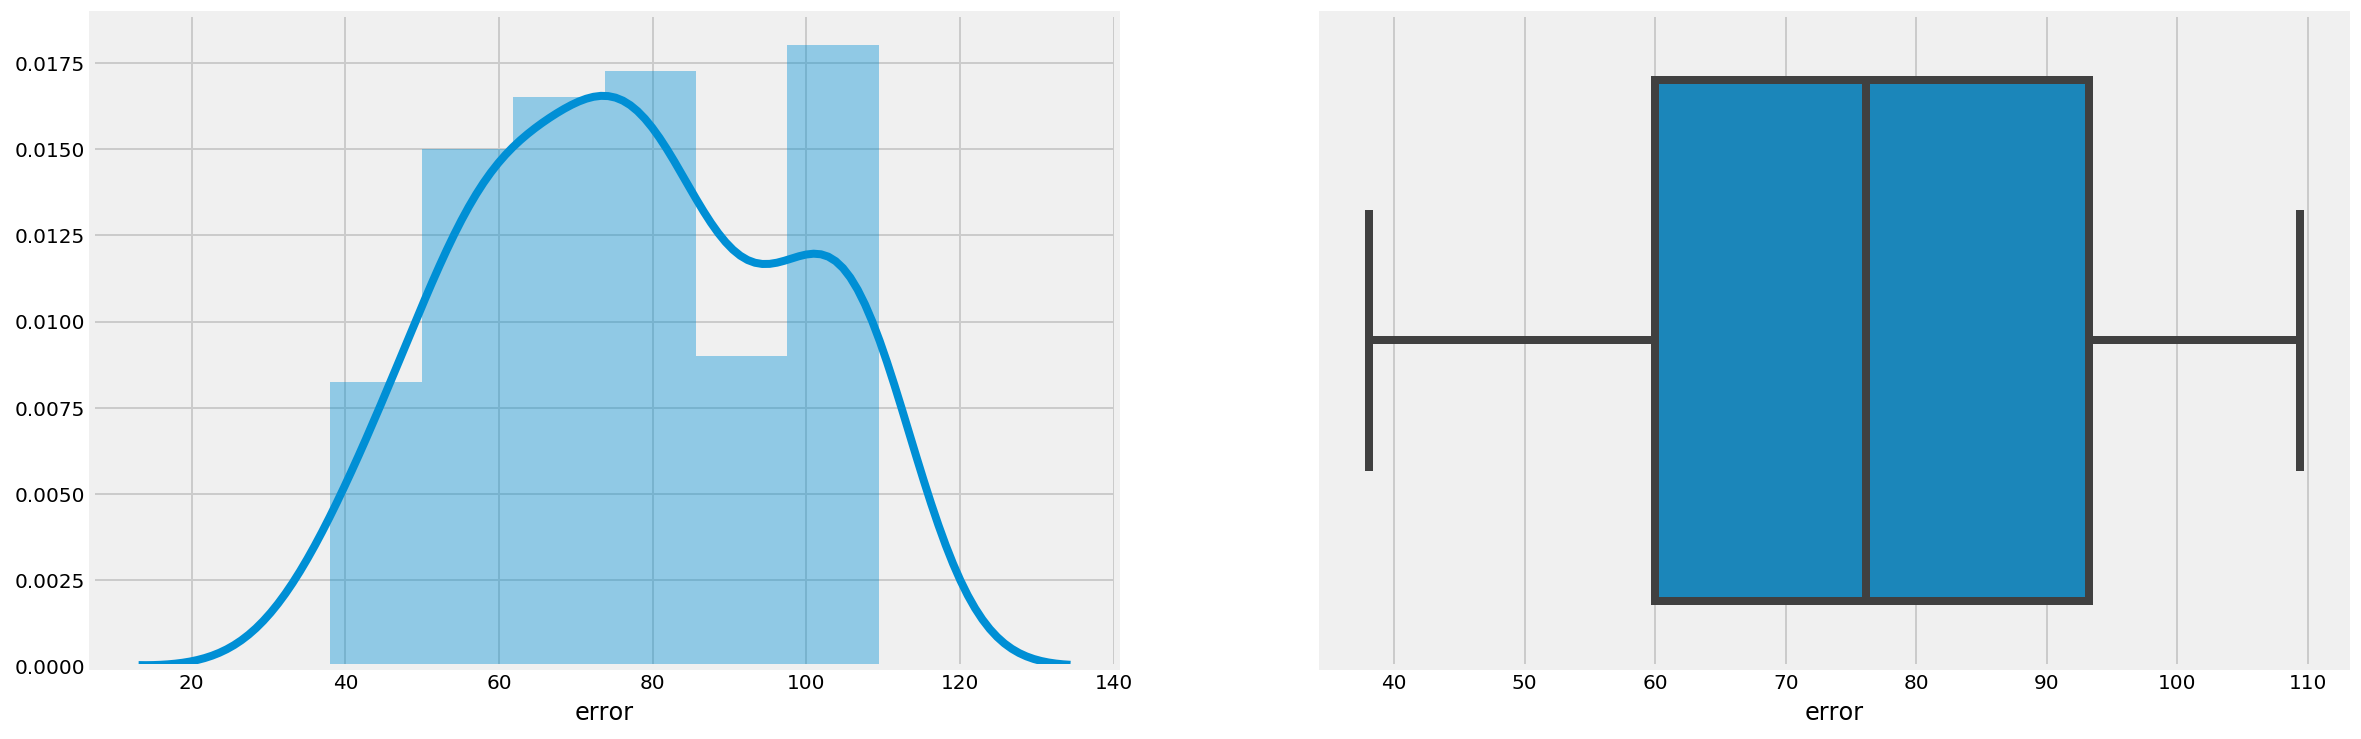

In [120]:
# Aggregate the prediction dataframes
preds = pd.concat([train_preds, val_preds, test_preds])
for el in tms.columns:
    preds['true_%s' % el] = tms[el]
    preds['error_%s' % el] = preds['preds_%s' % el] - preds['true_%s' % el]
preds['error'] = abs(preds[[x for x in preds.columns if 'error' in x]]).sum(axis = 1)

# Filter out extreme error percentiles and plot
fig, ax = plt.subplots(ncols = 2, figsize = (18, 6))
small_perc, large_perc = preds['error'].quantile([0.10, 0.90]).values
no_outliers = preds.loc[(preds.error > small_perc) & (preds.error < large_perc), 'error']
sns.distplot(no_outliers, ax = ax[0])
sns.boxplot(no_outliers, ax = ax[1])
display(preds['error'].quantile([0, 0.5, 0.75, 0.9, 0.95, 1]))

In [503]:
model.predict(forecastfuturesdata)

ValueError: non-broadcastable output operand with shape (151,) doesn't match the broadcast shape (151,151)

In [403]:
import quandl

In [404]:
quandl.ApiConfig.api_key= 'ztt5_Rp3hVKpUnN5sEG1'

In [484]:
data = quandl.get("ODA/PCOALAU_USD")

In [419]:
data.tail()

Value
Date             
2017-02-28  85.97
2017-03-31  86.33
2017-04-30  90.11
2017-05-31  80.12
2017-06-30  85.67

# Notes 

something to consider maybe to go into seconds trades predicting forward seconds , could be well suited for trading electricty... need better data

faster data

Simpler model with higher interpretability? Viariance bias trade-off


monte carlo simulations in the background

change the weights sdee what happpens with two